In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
from verification.val_db import (get_finalized_validation_datasets,
                                 read_validation_dataset,
                                 get_val_s3_path,
                                 get_image_table
                                )

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import numpy as np
from tqdm import tqdm
import rasterio
from matplotlib.colors import ListedColormap
from shapely.geometry import box
from rasterio.plot import show
from pathlib import Path
from verification.rio_tools import get_geopandas_features_from_array
import pandas as pd
import sklearn.metrics
import json
from verification.hls import get_hls_urls
from dem_stitcher.rio_tools import reproject_arr_to_match_profile, update_profile_resolution
import warnings
from verification.labels import resample_labels_into_percentage, reclassify_percentage_array_for_dswx

In [3]:
np.random.seed(0)

In [161]:
PLANET_ID = '20210924_082025_48_2424'#'20211011_155455_52_2262'#'20210928_211311_91_2457' #'20211002_155415_1009'
EQUAL_SAMPLING = True  # if false currently uses validation labels to determine size of each class sample
TOTAL_PIXELS_PER_SAMPLE = 500
NUMBER_OF_RANDOM_SAMPLES = 100  # aka number of trials
SAMPLE_FROM_DSWX = False # either sample from validation data or dswx (note this does not impact class sizes)
USE_ENTIRE_IMAGE = False # if True, random sampling and trials is moot and just directly samples from entire image
WITH_REPLACEMENT = False # whether to replace samples - will ensure equality if present, untested
CONFIDENCE_MINIMUM = 70 # at least confidence with this threshold
DOWNSAMPLE_BOTH_DS_TO_3_HA = False # downsample both datasets to 3 ha
USE_AEROSOL_MASK = True

# Saving data for assessments

In [5]:
token_samples = f'{NUMBER_OF_RANDOM_SAMPLES}-trials'
if USE_ENTIRE_IMAGE:
    toke_samples = 'entire_image_used_'
token_conf = f'_conf-geq-{CONFIDENCE_MINIMUM}'
token_class_sample = '_sample-from-dswx' if SAMPLE_FROM_DSWX else '_sample-from-val'
token_3ha = '_3ha-downsampled' if DOWNSAMPLE_BOTH_DS_TO_3_HA else ''

assessment_dir_name = token_samples + token_conf + token_class_sample + token_3ha
assessment_dir_name

'100-trials_conf-geq-70_sample-from-val'

In [6]:
out_dir = Path(f'out/assessment_data/{assessment_dir_name}') 
out_dir.mkdir(exist_ok=True, parents=True)
out_dir

PosixPath('out/assessment_data/100-trials_conf-geq-70_sample-from-val')

# Table of Finalized Data

In [7]:
df = get_finalized_validation_datasets()
df.head()

,bucket,calc_type,calculated_by,image_calc_name,image_name,notes,oversight_level,previous_name,processing_level,public,reviewed_by,s3_keys,upload_date,version,water_strata,water_stratum,geometry
0,opera-calval-database-dswx,Review,Charlie Marshak,20210903_150800_60_2458_classification_v2,20210903_150800_60_2458,Previous(Previous((CM): Used a NDWI threshold ...,None,20210903_150800_60_2458_classification_v1,Final,True,Alexander Handwerger,data/site/4_21/image/20210903_150800_60_2458/i...,20220930_152559,2.0,NaN,3.0,"POLYGON ((-71.87051 55.11002, -71.87051 55.166..."
1,opera-calval-database-dswx,Review,Charlie Marshak,20210903_152641_60_105c_classification_v2,20210903_152641_60_105c,Previous(This is water with lots of boalders p...,None,20210903_152641_60_105c_classification_v1.0,Final,True,Matthew Bonnema,data/site/4_11/image/20210903_152641_60_105c/i...,20221019_151359,2.0,NaN,3.0,"POLYGON ((-69.17307 54.40592, -69.17307 54.460..."
2,opera-calval-database-dswx,Review,Matthew Bonnema,20210904_093422_44_1065_classification_v1,20210904_093422_44_1065,Previous(Only water is a small pond near cente...,None,20210904_093422_44_1065_classification_v0,Final,True,Simran Sangha,data/site/1_31/image/20210904_093422_44_1065/i...,20221028_164450,1.0,NaN,1.0,"POLYGON ((17.28244 -29.97141, 17.28244 -29.916..."
3,opera-calval-database-dswx,Review,Alexander Handwerger,20210906_101112_28_225a_classification_v1,20210906_101112_28_225a,Previous(Supervised Classification using Semia...,None,20210906_101112_28_225a_classification_v0,Final,True,Charlie Marshak,data/site/3_28/image/20210906_101112_28_225a/i...,20220929_144718,1.0,NaN,2.0,"POLYGON ((-0.04389 43.05233, -0.04389 43.16776..."
4,opera-calval-database-dswx,Review,Charlie Marshak,20210909_000649_94_222b_classification_v1,20210909_000649_94_222b,Previous((CM): Looked at RGB and false color b...,None,20210909_000649_94_222b_classification_v0,Final,True,Alexander Handwerger,data/site/1_37/image/20210909_000649_94_222b/i...,20221027_162451,1.0,NaN,1.0,"POLYGON ((138.25959 -30.32811, 138.25959 -30.2..."


In [8]:
f'Currently, there are {df.shape[0]} finalized datasets'

'Currently, there are 52 finalized datasets'

# Site Name

In [9]:
df_site = get_image_table()
df_site.head()

,Strata,cloud_cover,collocated_dswx,datetime,dswx_cloud_cover,image_name,instrument,provider,resolution,site_coverage,site_name,timeDelta_days,geometry
0,3.0,0.0,HLS.S30.T04WDB.2021271T225541.v2.0,2021-09-29 21:28:09,4.0,20210929_212809_16_2442,PSB.SD,planetscope,3.0,90.820013,3_38,0.938606,"POLYGON ((-160.00896 69.30478, -160.21043 69.1..."
1,4.0,0.0,HLS.S30.T33WXP.2021270T104719.v2.0,2021-09-27 09:55:37,16.0,20210927_095537_0f15,PS2,planetscope,3.0,41.216128,4_43,0.039303,"POLYGON ((17.22275 66.09223, 17.16459 66.02168..."
2,3.0,0.0,HLS.L30.T40WEU.2021268T073033.v2.0,2021-09-25 07:27:12,2.0,20210925_072712_16_2254,PSB.SD,planetscope,3.0,72.272530,3_1,0.002335,"POLYGON ((59.00446 65.95517, 58.85023 65.76646..."
3,4.0,0.0,HLS.S30.T14VPQ.2021244T175911.v2.0,2021-09-01 17:52:05,2.0,20210901_175205_71_2426,PSB.SD,planetscope,3.0,100.000000,4_34,0.010000,"POLYGON ((-96.94381 62.88876, -97.07609 62.707..."
4,3.0,0.0,HLS.S30.T52VFP.2021253T023549.v2.0,2021-09-11 00:51:29,2.0,20210911_005129_82_106a,PS2.SD,planetscope,3.0,100.000000,3_30,0.924389,"POLYGON ((130.86458 61.50211, 130.95358 61.357..."


In [10]:
SITE_NAME = df_site[df_site.image_name == PLANET_ID]['site_name'].values[0]
SITE_NAME

'4_37'

# Read a Validation Dataset

In [11]:
X_val, p_val = read_validation_dataset(PLANET_ID)
p_val

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 3689, 'height': 3650, 'count': 1, 'crs': CRS.from_epsg(32735), 'transform': Affine(3.0, 0.0, 641640.0,
       0.0, -3.0, 8980494.0), 'blockysize': 2, 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}

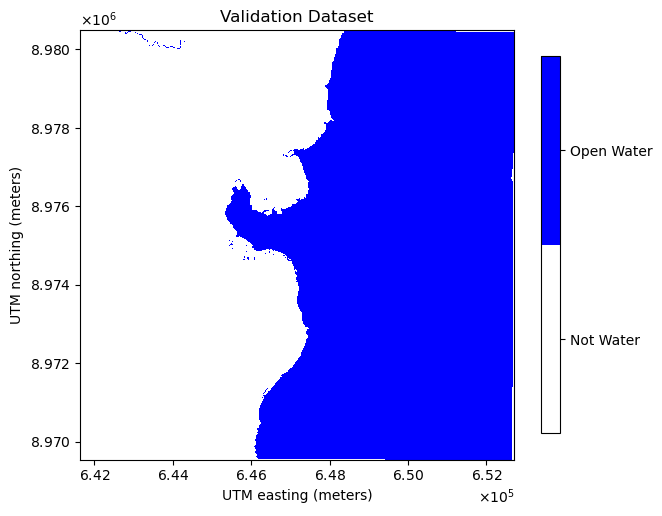

In [12]:
Y = X_val.astype(float)
Y[Y == 255] = np.nan

fontSize=10
fig, ax=plt.subplots(figsize=(7,7))
cmap = ListedColormap(['white', 'blue'])
im=ax.imshow(Y, interpolation='none',cmap=cmap,vmin=0,vmax=1)
show(Y, interpolation='none',cmap=cmap,vmin=0,vmax=1,transform=p_val['transform'],ax=ax)
cbar = fig.colorbar(im, ax=ax,shrink=0.7,ticks=[0.25, 0.75])
cbar.ax.set_yticklabels(['Not Water', 'Open Water']);  # vertically oriented colorbar
plt.xlabel('UTM easting (meters)',fontsize=fontSize)
plt.ylabel('UTM northing (meters)',fontsize=fontSize)
plt.xticks(fontsize = fontSize)
plt.yticks(fontsize = fontSize)
ax.set_title('Validation Dataset');
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(fontSize)
ax.xaxis.get_offset_text().set_fontsize(fontSize)

In [13]:
plt.close('all')

# Load Local Validation Table

In [14]:
df_validation_table = pd.read_csv('validation_table_data.csv')
df_validation_table.head()

,planet_id,hls_id,dswx_urls
0,20210903_150800_60_2458,HLS.L30.T18UXG.2021245T154154.v2.0,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
1,20210903_152641_60_105c,HLS.S30.T19UDA.2021245T154911.v2.0,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
2,20210904_093422_44_1065,HLS.S30.T33JYG.2021248T082559.v2.0,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
3,20210906_101112_28_225a,HLS.S30.T30TYN.2021248T105621.v2.0,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
4,20210909_000649_94_222b,HLS.L30.T54JTM.2021251T003848.v2.0,https://opera-pst-rs-pop1.s3.us-west-2.amazona...


# Get Associated HLS Id

In [15]:
HLS_ID = df_validation_table[df_validation_table.planet_id == PLANET_ID].hls_id.iloc[0]
HLS_ID

'HLS.S30.T35LPK.2021267T080651.v2.0'

In [16]:
hls_urls_dict = get_hls_urls(HLS_ID)
fmask_url = hls_urls_dict['hls_url_Fmask']
fmask_url

'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T35LPK.2021267T080651.v2.0/HLS.S30.T35LPK.2021267T080651.v2.0.Fmask.tif'

# Get DSWx Products

In [17]:
dswx_urls = df_validation_table[df_validation_table.planet_id == PLANET_ID].dswx_urls.iloc[0].split(',')
dswx_urls

['https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx-HLS_T35LPK_20210924T080651Z_20230110T183515Z_S2A_30_v1.0/OPERA_L3_DSWx-HLS_T35LPK_20210924T080651Z_20230110T183515Z_S2A_30_v1.0_B01_WTR.tif',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx-HLS_T35LPK_20210924T080651Z_20230110T183515Z_S2A_30_v1.0/OPERA_L3_DSWx-HLS_T35LPK_20210924T080651Z_20230110T183515Z_S2A_30_v1.0_B02_BWTR.tif',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx-HLS_T35LPK_20210924T080651Z_20230110T183515Z_S2A_30_v1.0/OPERA_L3_DSWx-HLS_T35LPK_20210924T080651Z_20230110T183515Z_S2A_30_v1.0_B03_CONF.tif',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx-HLS_T35LPK_20210924T080651Z_20230110T183515Z_S2A_30_v1.0/OPERA_L3_DSWx-HLS_T35LPK_20210924T080651Z_20230110T183515Z_S2A_30_v1.0_B04_DIAG.tif',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx-HLS_T35LPK_20210924T080651Z_20230110T18

In [18]:
with rasterio.open(dswx_urls[0]) as ds:
    X_dswx = ds.read(1)
    p_dswx = ds.profile
    crs_dswx = ds.crs
    colormap = ds.colormap(1)
    dswx_crs = ds.crs

In [19]:
with rasterio.open(dswx_urls[2]) as ds:
    conf_dsx_original = ds.read(1)
    p_dswx_conf_original = ds.profile
    conf_colormap = ds.colormap(1)

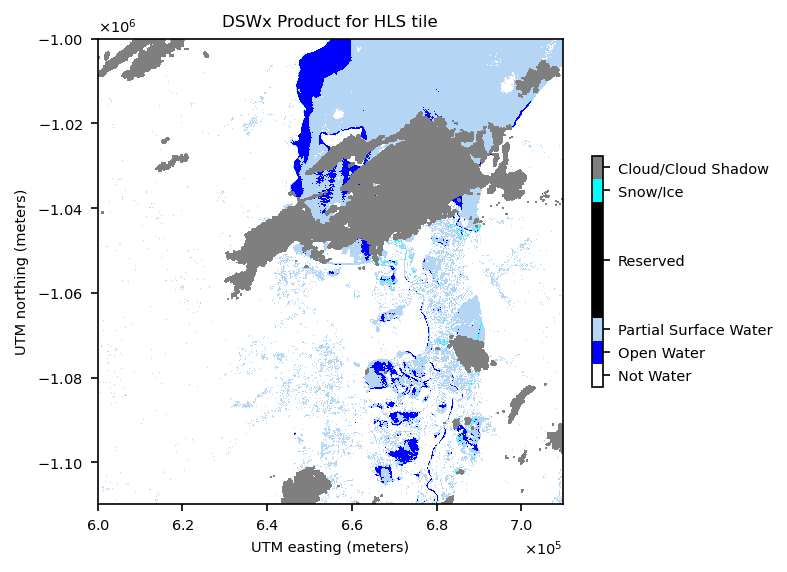

In [20]:
fontSize=7
fontSizeTitle=8
fig, ax = plt.subplots(dpi=150,figsize=(5,5))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
im_dswx=ax.imshow(X_dswx, interpolation='none',cmap=cmap,vmin=0,vmax=255)
show(X_dswx, interpolation='none',cmap=cmap,vmin=0,vmax=255,transform=p_dswx['transform'],ax=ax)
cbar=fig.colorbar(im_dswx,ax=ax,shrink=0.4,ticks=[0.5, 1.5, 2.5,5.5,8.5, 9.5])
cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Reserved','Snow/Ice','Cloud/Cloud Shadow'],fontsize=fontSize)   
cbar.ax.set_ylim(0,10)
plt.xlabel('UTM easting (meters)',fontsize=fontSize)
plt.ylabel('UTM northing (meters)',fontsize=fontSize)
plt.xticks(fontsize = fontSize)
plt.yticks(fontsize = fontSize)
ax.set_title('DSWx Product for HLS tile',fontsize=fontSizeTitle);
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(fontSize)
ax.xaxis.get_offset_text().set_fontsize(fontSize)

In [21]:
plt.close('all')

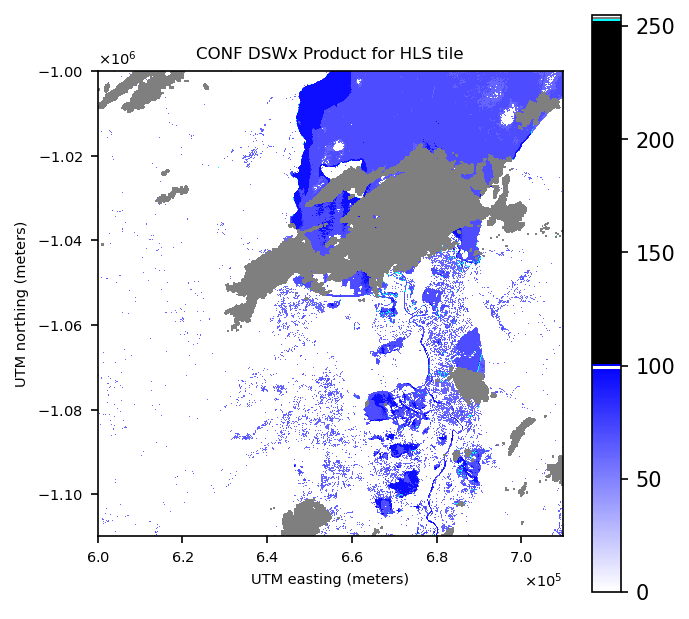

In [22]:
fontSize=7
fontSizeTitle=8
fig, ax = plt.subplots(dpi=150,figsize=(5,5))
cmap = ListedColormap([np.array(conf_colormap[key]) / 255 for key in range(256)])
im_dswx_conf=ax.imshow(conf_dsx_original, 
                  interpolation='none',
                  cmap=cmap,
                  vmin=0,
                  vmax=255)
show(conf_dsx_original, 
     interpolation='none',
     cmap=cmap,
     vmin=0,vmax=255,
     transform=p_dswx['transform'],
     ax=ax)
cbar=fig.colorbar(im_dswx_conf,ax=ax)

plt.xlabel('UTM easting (meters)',fontsize=fontSize)
plt.ylabel('UTM northing (meters)',fontsize=fontSize)
plt.xticks(fontsize = fontSize)
plt.yticks(fontsize = fontSize)
ax.set_title('CONF DSWx Product for HLS tile',fontsize=fontSizeTitle);
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(fontSize)
ax.xaxis.get_offset_text().set_fontsize(fontSize)

In [23]:
plt.close('all')

# Compare Extents

Inspect the DSWx Subset and it's corresponding Validation Dataset

In [24]:
val_url = get_val_s3_path(PLANET_ID)
with rasterio.open(val_url) as ds:
    val_bounds = list(ds.bounds)
    val_crs = ds.crs

The two datasets are frequently in the same CRS. Just in case, we reproject to DSWx projection.

In [25]:
df_val_bounds = gpd.GeoDataFrame(geometry=[box(*val_bounds).buffer(60)],
                                 crs=val_crs)
df_val_bounds = df_val_bounds.to_crs(dswx_crs)
df_val_bounds

,geometry
0,"POLYGON ((652707.000 -1030516.000, 641640.000 ..."


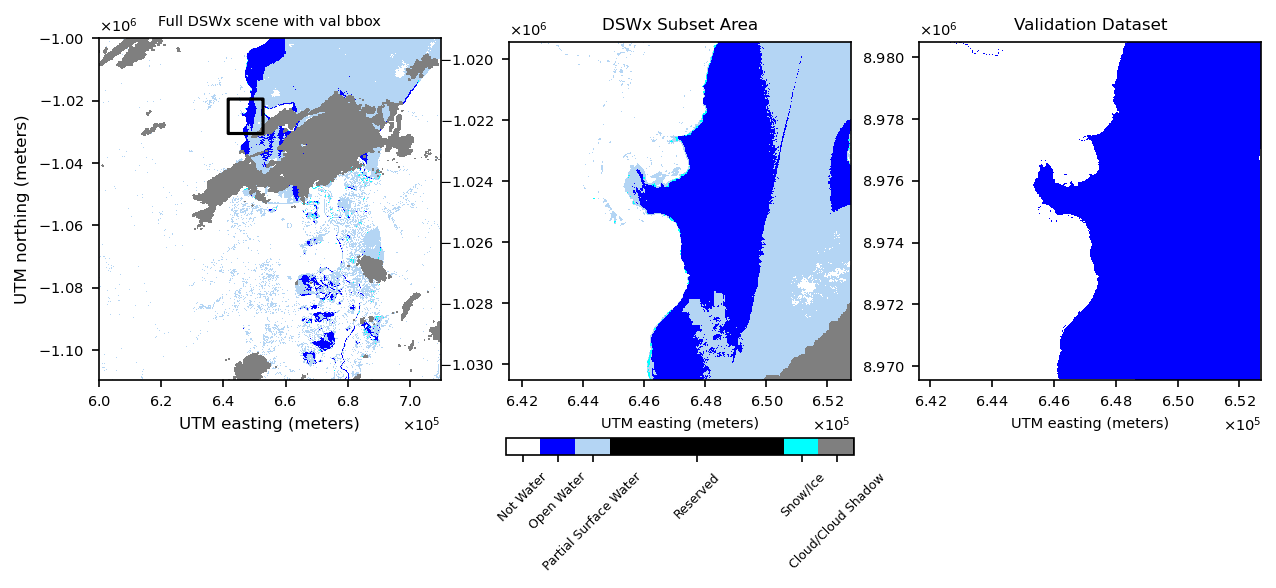

In [26]:
fontSize=7
fontSizeTitles=8
fig, ax = plt.subplots(1, 3, dpi=150, figsize=(10, 10))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])

show(X_dswx, cmap=cmap, transform=p_dswx['transform'], vmin=0, vmax=255, interpolation='none', ax=ax[0])
df_val_bounds.to_crs(crs_dswx).boundary.plot(ax=ax[0], color='black')
ax[0].set_title('Full DSWx scene with val bbox',fontsize=fontSize)
ax[0].set_xlabel('UTM easting (meters)',fontsize=fontSizeTitles)
ax[0].set_ylabel('UTM northing (meters)',fontsize=fontSizeTitles)
ax[0].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax[0].tick_params(axis='both', which='major', labelsize=fontSize)
ax[0].yaxis.get_offset_text().set_fontsize(fontSize)
ax[0].xaxis.get_offset_text().set_fontsize(fontSize)

show(X_dswx, cmap=cmap, transform=p_dswx['transform'], vmin=0,vmax=255, interpolation='none', ax=ax[1])
val_bounds_dswx = df_val_bounds.to_crs(crs_dswx).total_bounds
ax[1].set_xlim(val_bounds_dswx[0], val_bounds_dswx[2])
ax[1].set_ylim(val_bounds_dswx[1], val_bounds_dswx[3])
ax[1].set_title('DSWx Subset Area',fontsize=fontSizeTitles)
ax[1].set_xlabel('UTM easting (meters)',fontsize=fontSize)
ax[1].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax[1].tick_params(axis='both', which='major', labelsize=fontSize)
ax[1].yaxis.get_offset_text().set_fontsize(fontSize)
ax[1].xaxis.get_offset_text().set_fontsize(fontSize)

show(X_val, transform=p_val['transform'], ax=ax[2], interpolation='none', cmap=cmap, vmin=0, vmax=255)
ax[2].set_title('Validation Dataset',fontsize=fontSizeTitles)
ax[2].set_xlabel('UTM easting (meters)',fontsize=fontSize)
ax[2].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax[2].tick_params(axis='both', which='major', labelsize=fontSize)
ax[2].yaxis.get_offset_text().set_fontsize(fontSize)
ax[2].xaxis.get_offset_text().set_fontsize(fontSize)

cbar=fig.colorbar(im_dswx,ax=ax,ticks=[0.5, 1.5, 2.5,5.5,8.5, 9.5],shrink=0.3,orientation='horizontal',fraction=0.32,pad=.05)
cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Reserved','Snow/Ice','Cloud/Cloud Shadow'],rotation=45)   
cbar.ax.tick_params(labelsize=6)
cbar.ax.set_xlim(0,10);

In [27]:
plt.close('all')

# Get Fmask

In [28]:
from osgeo import gdal

# GDAL configs used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption("GDAL_HTTP_UNSAFESSL", "YES")
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','YES')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','FALSE')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')

In [29]:
with rasterio.open(fmask_url) as ds:
    X_fmask = ds.read(1)
    p_fmask = ds.profile

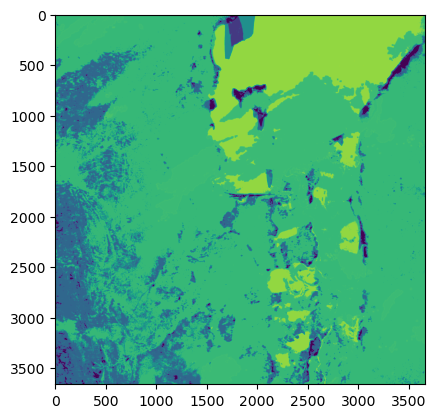

In [30]:
plt.imshow(X_fmask)


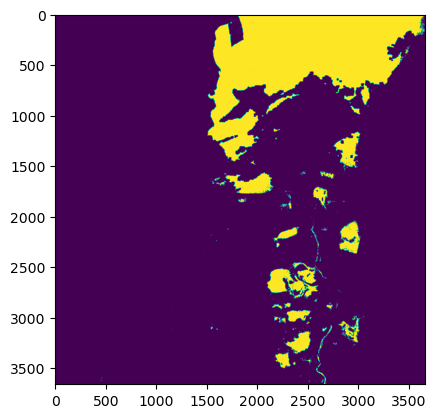

In [31]:

# 224 <-> 11100000
X_224 = (X_fmask == 224)
# 160 -> 10100000
X_160 = (X_fmask == 160)

X_aerosol = X_224 | X_160
plt.imshow(X_aerosol)

# Crop Datasets

In [32]:
from dem_stitcher.rio_window import read_raster_from_window

In [33]:
X_dswx_c_original, p_dswx_c_original = read_raster_from_window(dswx_urls[0], 
                                                               list(df_val_bounds.total_bounds), 
                                                               df_val_bounds.crs)

In [34]:
conf_dswx_c_original, _ = read_raster_from_window(dswx_urls[2], 
                                                  list(df_val_bounds.total_bounds), 
                                                  df_val_bounds.crs)

In [155]:
tmp_dir = Path('tmp')
tmp_dir.mkdir(exist_ok=True)

In [156]:
with rasterio.open(tmp_dir / 'aerosol.tif', 'w', **p_fmask) as ds:
    ds.write(X_aerosol.astype(np.uint8), 1)

In [157]:
X_aerosol_c, _ = read_raster_from_window('aerosol.tif', 
                                         list(df_val_bounds.total_bounds), 
                                         df_val_bounds.crs)
X_aerosol_c = X_aerosol_c.astype(bool)

In [158]:
assert X_aerosol_c.shape == X_dswx_c_original.shape

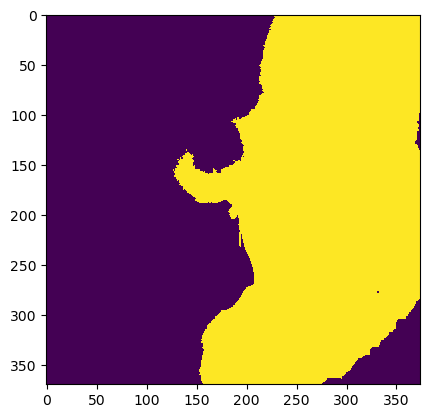

In [159]:
plt.imshow(X_aerosol_c)

# Exclude Small Water bodies in validation

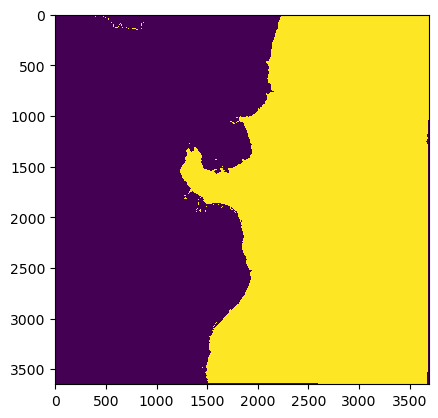

In [35]:
from skimage.measure import label, regionprops
from skimage.color import label2rgb

X_val_water_only = (X_val == 1).astype(int)
plt.imshow(X_val_water_only, interpolation='none')

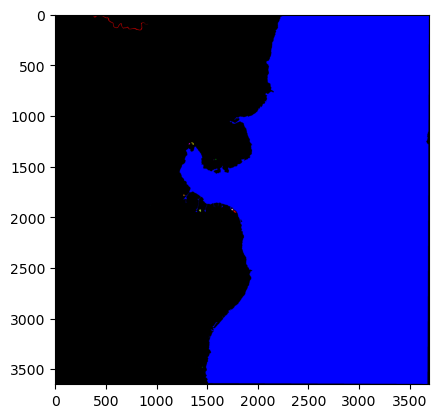

In [36]:
water_labels = label(X_val_water_only, connectivity=2)
water_labels_rbg = label2rgb(water_labels)
plt.imshow(water_labels_rbg)

In [37]:
props = regionprops(water_labels)

if props:
    print(props[0].area)

3613


As an example, let's see what `props` does:

In [38]:
N = min(len(props), 4)
for k in range(N):
    print('key/size label: ', k)
    print('One way:', (water_labels == (k+1)).sum())
    print('region props: ', props[k].area)

key/size label:  0
One way: 3613
region props:  3613
key/size label:  1
One way: 6789969
region props:  6789969
key/size label:  2
One way: 212
region props:  212
key/size label:  3
One way: 109
region props:  109


In [39]:
labels_to_exclude = [(k+1) for (k, prop) in enumerate(props) if prop.area <= 3333]
size_mask = np.isin(water_labels, labels_to_exclude)

Text(0.5, 1.0, 'Water bodies to be excluded')

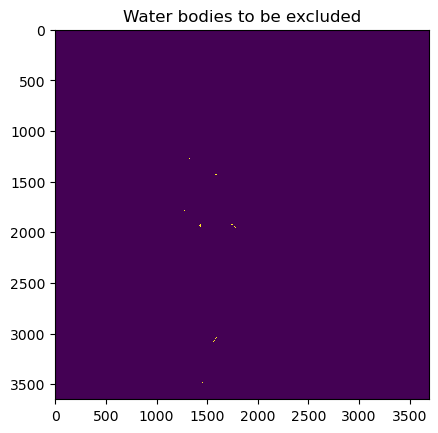

In [40]:
plt.imshow(size_mask, interpolation='none')
plt.title('Water bodies to be excluded')

In [41]:
plt.close('all')

# Resample Validation Dataset to DSWx Product

This extracts a percent open surface water in HLS frame.

In [42]:
if DOWNSAMPLE_BOTH_DS_TO_3_HA:
    p_dswx_c_3ha_temp = update_profile_resolution(p_dswx_c_original, 100 * np.sqrt(3))
    p_dswx_c_3ha_temp['dtype'] = 'float32'
    X_dswx_psw_percentage, p_dswx_c_3ha = resample_labels_into_percentage(X_dswx_c_original, 
                                                                          p_dswx_c_original, 
                                                                          p_dswx_c_3ha_temp, 
                                                                          2)
    X_dswx_psw_percentage *= .75
    X_dswx_osw_percentage, _ = resample_labels_into_percentage(X_dswx_c_original, 
                                                               p_dswx_c_original, 
                                                               p_dswx_c_3ha, 
                                                               1)
    X_dswx_c_3ha_percentage = X_dswx_psw_percentage + X_dswx_osw_percentage
    X_dswx_c_3ha_percentage = np.clip(X_dswx_c_3ha_percentage, 0, 1)
    
    

In [43]:
if DOWNSAMPLE_BOTH_DS_TO_3_HA:
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(X_dswx_psw_percentage, vmin=0, vmax=1)
    ax[0].set_title('Percent PSW (using partial surface water = 50%)')
    
    
    ax[1].imshow(X_dswx_osw_percentage, vmin=0, vmax=1)
    ax[1].set_title('Percent OSW')
    
    im = ax[2].imshow(X_dswx_c_3ha_percentage, vmin=0, vmax=1)
    ax[2].set_title('Percent OSW')
    fig.colorbar(im, ax=ax, label='Percent OSW')

In [44]:
plt.close('all')
if DOWNSAMPLE_BOTH_DS_TO_3_HA:
    X_dswx_c = reclassify_percentage_array_for_dswx(X_dswx_c_3ha_percentage)
    p_dswx_c = p_dswx_c_3ha.copy()
    p_dswx_c['dtype'] = np.uint8
    p_dswx_c['nodata'] = 255
    
else:
    X_dswx_c = X_dswx_c_original
    p_dswx_c = p_dswx_c_original.copy()

In [45]:
p_dswx_c_float = p_dswx_c.copy()
p_dswx_c_float['dtype'] = 'float32'

X_val_temp = X_val.astype('float32')
X_val_temp[(X_val == 10) | (X_val == 255) | size_mask] = np.nan
p_val_temp = p_val.copy()
p_val_temp['nodata'] = np.nan

X_val_per_w, p_per_int = resample_labels_into_percentage(X_val_temp, p_val_temp, p_dswx_c_float, 1)

In [46]:
if DOWNSAMPLE_BOTH_DS_TO_3_HA:
    conf_dswx_c, _ = reproject_arr_to_match_profile(conf_dswx_c_original, 
                                                    p_dswx_conf_original, 
                                                    p_per_int)
    conf_dswx_c = conf_dswx_c[0, ...]
    
else:
    conf_dswx_c = conf_dswx_c_original

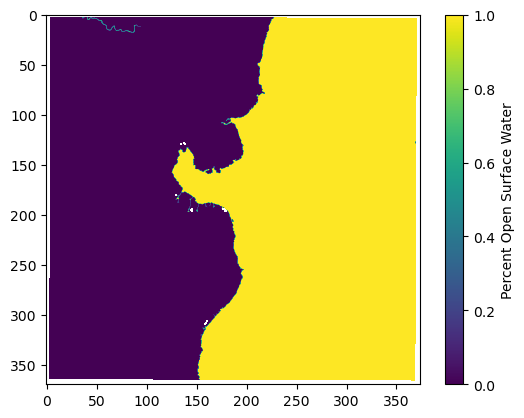

In [47]:
plt.imshow(X_val_per_w, vmin=0, vmax=1)
cbar = plt.colorbar(label='Percent Open Surface Water')

In [48]:
plt.close('all')

Convert to DSWx Labels.

In [49]:
X_val_r = reclassify_percentage_array_for_dswx(X_val_per_w)

In [50]:
p_dswx_c

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 374, 'height': 370, 'count': 1, 'crs': CRS.from_wkt('PROJCS["UTM Zone 35, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not_specified_based_on_WGS_84_spheroid",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",27],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 641550.0,
       0.0, -30.0, -1019430.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

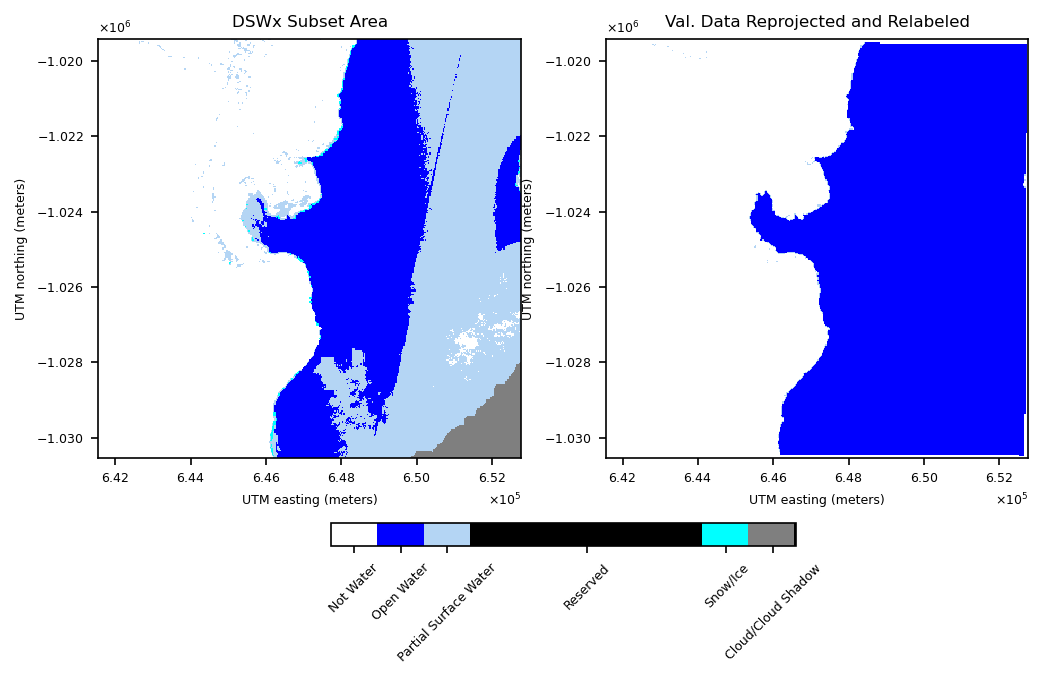

In [51]:
fontSize=6
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(8, 8))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
im=ax[0].imshow(X_dswx_c, interpolation='none',cmap=cmap,vmin=0,vmax=255)

show(X_dswx_c, cmap=cmap, transform=p_dswx_c['transform'], interpolation='none', ax=ax[0], vmin=0,vmax=255)
ax[0].set_title('DSWx Subset Area',fontsize=8)
ax[0].set_xlabel('UTM easting (meters)',fontsize=fontSize)
ax[0].set_ylabel('UTM northing (meters)',fontsize=fontSize)
ax[0].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax[0].tick_params(axis='both', which='major', labelsize=fontSize)
ax[0].yaxis.get_offset_text().set_fontsize(fontSize)
ax[0].xaxis.get_offset_text().set_fontsize(fontSize)

show(X_val_r, 
     cmap=cmap, 
     transform=p_dswx_c['transform'], 
     interpolation='none',
     ax=ax[1], vmin=0, vmax=255)
ax[1].set_title('Val. Data Reprojected and Relabeled',fontsize=8)
ax[1].set_xlabel('UTM easting (meters)',fontsize=fontSize)
ax[1].set_ylabel('UTM northing (meters)',fontsize=fontSize)

ax[1].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax[1].tick_params(axis='both', which='major', labelsize=fontSize)
ax[1].yaxis.get_offset_text().set_fontsize(fontSize)
ax[1].xaxis.get_offset_text().set_fontsize(fontSize)

cbar=fig.colorbar(im,ax=ax,ticks=[0.5, 1.5,2.5,5.5,8.5,9.5],shrink=0.5,orientation='horizontal',pad=.071)
cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Reserved','Snow/Ice','Cloud/Cloud Shadow'],rotation=45)   
cbar.ax.tick_params(labelsize=fontSize)
cbar.ax.set_xlim(0,10);

In [52]:
plt.close('all')

**Warning**: In many cases, the UTM zone of the validation dataset and the OPERA DSWx product do not match. So despite some of the side-by-side plots that appear parallel, the rotation above can come as surprise. A slight rotation will occur if the below CRS's are different.

In [53]:
print('DSWx CRS: ', p_dswx['crs'])
print('Validation CRS: ', p_val['crs'])

DSWx CRS:  PROJCS["UTM Zone 35, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not_specified_based_on_WGS_84_spheroid",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",27],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Validation CRS:  EPSG:32735


# Save Relevant Rasters for Inspection

In [54]:
dswx_urls[0].split('_B01')[0]

'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx-HLS_T35LPK_20210924T080651Z_20230110T183515Z_S2A_30_v1.0/OPERA_L3_DSWx-HLS_T35LPK_20210924T080651Z_20230110T183515Z_S2A_30_v1.0'

In [55]:
DSWx_ID = dswx_urls[0].split('_B01')[0].split('/')[-1]
DSWx_ID

'OPERA_L3_DSWx-HLS_T35LPK_20210924T080651Z_20230110T183515Z_S2A_30_v1.0'

In [56]:
dswx_dir = out_dir / DSWx_ID
dswx_dir.mkdir(exist_ok=True)

In [57]:
p_val_r = p_dswx_c.copy()
p_val_r['dtype'] = np.uint8
p_val_r['nodata'] = 255

with rasterio.open(dswx_dir / f'validation_r_{DSWx_ID}.tif', 'w', **p_val_r) as ds:
    ds.write(X_val_r, 1)
    ds.write_colormap(1, colormap)

In [58]:
p_perc_r = p_dswx_c.copy()
p_perc_r['dtype'] = np.float32
p_perc_r['nodata'] = np.nan

with rasterio.open(dswx_dir / f'percent_r_{DSWx_ID}.tif', 'w', **p_perc_r) as ds:
    ds.write(X_val_per_w, 1)

In [59]:
with rasterio.open(dswx_dir / f'{DSWx_ID}.tif', 'w', **p_dswx_c) as ds:
    ds.write(X_dswx_c, 1)
    ds.write_colormap(1, colormap)

In [60]:
with rasterio.open(dswx_dir / f'validation_original_{DSWx_ID}.tif', 'w', **p_val) as ds:
    ds.write(X_val, 1)
    ds.write_colormap(1, colormap)

# Scene-wise stratified sampling

In [61]:
X_dswx_c.shape

(370, 374)

In [62]:
X_val_r.shape

(370, 374)

In [63]:
shared_mask = (X_val_r == 255) | ~(np.isin(X_dswx_c, [0, 1, 2]))

if CONFIDENCE_MINIMUM:
    confidence_mask = (conf_dswx_c < CONFIDENCE_MINIMUM)
    shared_mask = (shared_mask | confidence_mask)

In [162]:
if USE_AEROSOL_MASK:
    shared_mask = (shared_mask | X_aerosol_c)

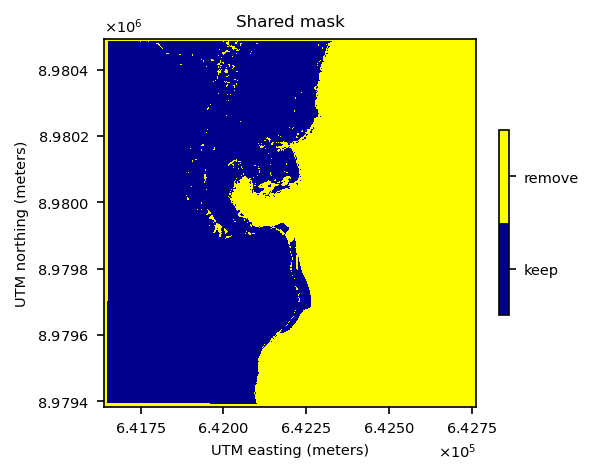

In [163]:
fontSize=7
fig, ax = plt.subplots(dpi=150,figsize=(4, 4))
cmap = ListedColormap(['darkblue', 'yellow'])
im=ax.imshow(shared_mask, interpolation='none',cmap=cmap,vmin=np.nanmin(shared_mask),vmax=np.nanmax(shared_mask))
show(shared_mask, transform=p_val['transform'], interpolation='none', vmin=np.nanmin(shared_mask),vmax=np.nanmax(shared_mask),ax=ax,cmap=cmap)  
cbar=fig.colorbar(im,ax=ax,shrink=0.4,ticks=[0.25, .75])
cbar.set_ticklabels(['keep', 'remove'],fontsize=fontSize)   
cbar.ax.set_ylim(0,1)
ax.set_title('Shared mask',fontsize=8);
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(fontSize)
ax.xaxis.get_offset_text().set_fontsize(fontSize)
plt.xlabel('UTM easting (meters)',fontsize=fontSize)
plt.ylabel('UTM northing (meters)',fontsize=fontSize)
plt.yticks(fontsize=fontSize)
plt.xticks(fontsize=fontSize);

In [164]:
plt.close('all')

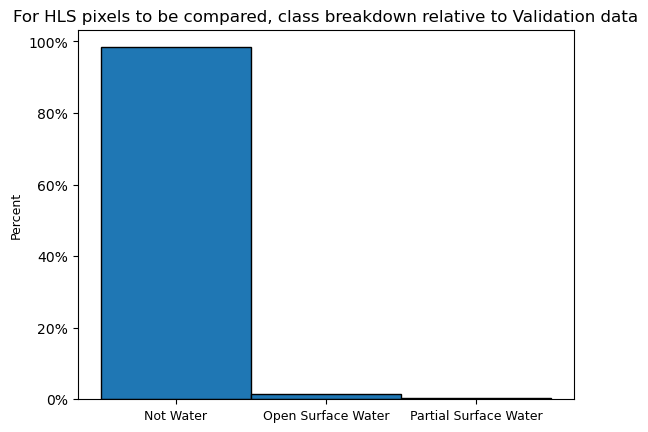

In [165]:
percents, _, _ = plt.hist(X_val_r[~shared_mask], bins=3, range=(0, 3), density=True, edgecolor='black')
plt.xticks(np.arange(0, 3)+.5, ['Not Water', 'Open Surface Water', 'Partial Surface Water'],fontsize=9)
plt.ylabel('Percent',fontsize=9)
plt.title('For HLS pixels to be compared, class breakdown relative to Validation data');
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

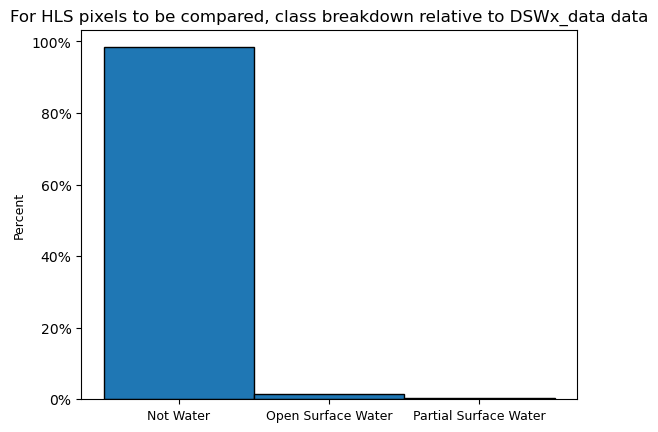

In [166]:
percents_dswx, _, _ = plt.hist(X_dswx_c[~shared_mask], bins=3, range=(0, 3), density=True, edgecolor='black')
plt.xticks(np.arange(0, 3)+.5, ['Not Water', 'Open Surface Water', 'Partial Surface Water'],fontsize=9)
plt.ylabel('Percent',fontsize=9)
plt.title('For HLS pixels to be compared, class breakdown relative to DSWx_data data');
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [167]:
plt.close('all')

In [168]:
f'Percents per DSWx class: {percents_dswx}'

'Percents per DSWx class: [0.98363129 0.01377776 0.00259095]'

In [169]:
f'Percents per validation class: {percents}'

'Percents per validation class: [0.98357033 0.01425022 0.00217945]'

In [170]:
sample_size_per_label = [int(np.ceil(percents[label] * TOTAL_PIXELS_PER_SAMPLE)) for label in [0, 1, 2]]
if EQUAL_SAMPLING:
    present_classes = (percents > 0).sum()
    #always multiply by 3 because we have 3 labels
    # sample sizes are modified depending on availability (see cell below)
    sample_size_per_label = [int(np.ceil(TOTAL_PIXELS_PER_SAMPLE / present_classes))] * 3
    
sample_size_per_label

[167, 167, 167]

In [171]:
validation_hls_pixels = X_val_r[~shared_mask]
dswx_hls_pixels = X_dswx_c[~shared_mask]

sample_pixels = dswx_hls_pixels if SAMPLE_FROM_DSWX else validation_hls_pixels

sample_str = 'dswx' if SAMPLE_FROM_DSWX else 'the validation dataset'
f'We are sampling from {sample_str}'

'We are sampling from the validation dataset'

In [172]:
NUMBER_OF_RANDOM_SAMPLES = 100

In [173]:
# list of lists, 
# each index corresponds to class label 0, 1, 2 and the list will contain
# indices within the flattend array of that label
stratified_selection = [[] for k in range(NUMBER_OF_RANDOM_SAMPLES)] 

for random_sample in range(NUMBER_OF_RANDOM_SAMPLES):
    for label in [0, 1, 2]:
        # Sampling from PRODUCT PIXELS now
        indices = np.argwhere(sample_pixels == label).ravel()

        # Determines if there are enough samples otherwise select the total number of samples available
        subset_size = sample_size_per_label[label]
        if not WITH_REPLACEMENT:
            subset_size = np.minimum(subset_size, len(indices))
            sample_size_per_label[label] = subset_size

        indices_subset = np.random.choice(indices, subset_size, replace=WITH_REPLACEMENT)
        stratified_selection[random_sample].append(indices_subset)
sample_size_per_label

[167, 167, 143]

In [174]:
validation_labels = [[label for label in [0, 1, 2] 
                      for k in range(len(stratified_selection[random_sample][label]))]
                     for j in range(NUMBER_OF_RANDOM_SAMPLES)
                    ]
opera_dswx_labels = [[dswx_label 
                     for label in [0, 1, 2] 
                     for dswx_label in dswx_hls_pixels[stratified_selection[random_sample][label]]]
                     for random_sample in range(NUMBER_OF_RANDOM_SAMPLES)
                    ]
len(validation_labels[0]), len(opera_dswx_labels[0])

(477, 477)

In [175]:
X_samples = np.full(shared_mask.shape, 0)
temp = X_samples[~shared_mask]

k = 1

RANDOM_SAMPLE_FOR_INSPECTION = 0

sample2validation = {}
sample2dswx = {}

for label in [0, 1, 2]:
    for ind in stratified_selection[RANDOM_SAMPLE_FOR_INSPECTION][label]:
        temp[ind] = k
        # ensure we can look up the sample id and find the correct label for the different datasets we compare
        sample2validation[k] = label
        sample2dswx[k] = dswx_hls_pixels[ind]
        k += 1
    
X_samples[~shared_mask] = temp
(X_samples > 0).sum()

477

In [176]:
features = get_geopandas_features_from_array(# Note 8 bits is not enough for 500 points
                                             X_samples.astype(np.int32), 
                                             transform=p_dswx_c['transform'],
                                             mask=(X_samples==0),
                                             label_name='sample_id'
                                            )
df_samples = gpd.GeoDataFrame.from_features(features, 
                                            crs=p_dswx_c['crs'])
df_samples['val_label'] = df_samples['sample_id'].map(lambda label: sample2validation[label])
df_samples['dswx_label'] = df_samples['sample_id'].map(lambda label: sample2dswx[label])

df_samples.head()

,geometry,sample_id,val_label,dswx_label
0,"POLYGON ((648390.000 -1019520.000, 648390.000 ...",394.0,2,2
1,"POLYGON ((642060.000 -1019550.000, 642060.000 ...",125.0,0,0
2,"POLYGON ((642780.000 -1019550.000, 642780.000 ...",469.0,2,0
3,"POLYGON ((642840.000 -1019550.000, 642840.000 ...",434.0,2,0
4,"POLYGON ((642810.000 -1019580.000, 642810.000 ...",385.0,2,0


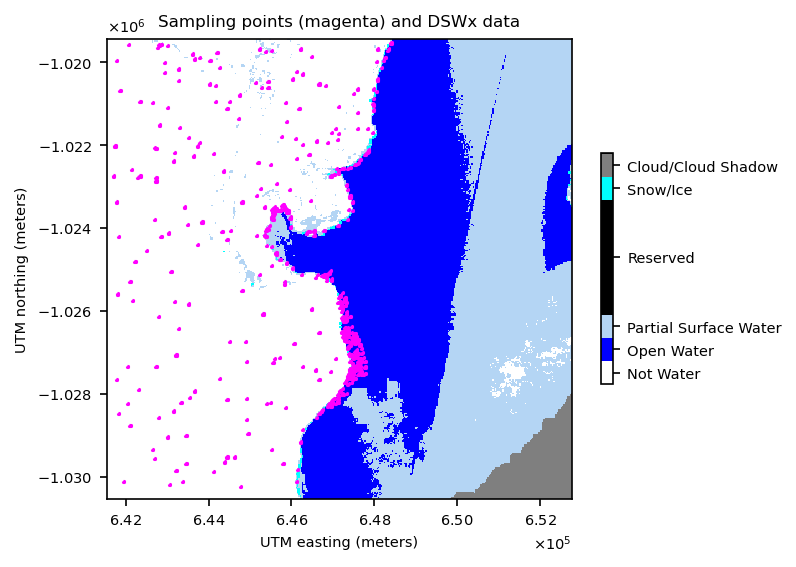

In [177]:
fontSize=7
fontSizeTitle=8
fig, ax = plt.subplots(dpi=150,figsize=(5,5))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
out = show(X_dswx_c,
     cmap=cmap,
     transform=p_dswx_c['transform'],
     interpolation='none',
     ax=ax,vmin=0,vmax=255)
df_samples.to_crs(p_dswx_c['crs']).boundary.plot(ax=ax, color='magenta',alpha=1)
ax.set_title('Sampling points (magenta) and DSWx data',fontsize=fontSizeTitle)
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
plt.xlabel('UTM easting (meters)',fontsize=fontSize)
plt.ylabel('UTM northing (meters)',fontsize=fontSize)

im_dswx = out.get_images()[0]
cbar=fig.colorbar(im_dswx,ax=ax,shrink=0.4,ticks=[0.5, 1.5, 2.5,5.5,8.5, 9.5])
cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Reserved','Snow/Ice','Cloud/Cloud Shadow'],fontsize=fontSize)   
cbar.ax.set_ylim(0,10);
ax.yaxis.get_offset_text().set_fontsize(fontSize)
ax.xaxis.get_offset_text().set_fontsize(fontSize)
plt.yticks(fontsize=fontSize)
plt.xticks(fontsize=fontSize);

In [178]:
plt.close('all')

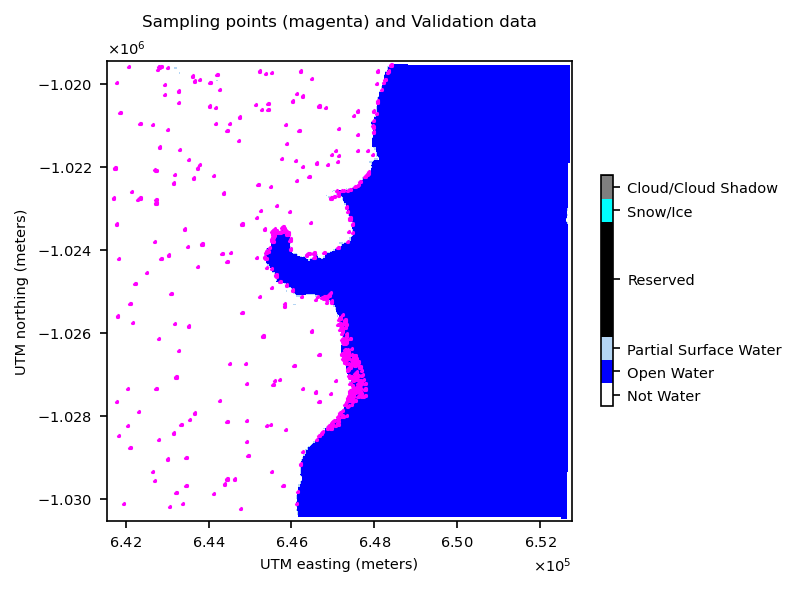

In [179]:
fontSize=7
fontSizeTitle=8
fig, ax = plt.subplots(dpi=150,figsize=(5,5))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
out = show(X_val_r,cmap=cmap,transform=p_dswx_c['transform'],interpolation='none',ax=ax,vmin=0,vmax=255)
df_samples.to_crs(p_dswx_c['crs']).boundary.plot(ax=ax, color='magenta',alpha=1)
ax.set_title('Sampling points (magenta) and Validation data',fontsize=fontSizeTitle)
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
plt.xlabel('UTM easting (meters)',fontsize=fontSize)
plt.ylabel('UTM northing (meters)',fontsize=fontSize)

im_dswx = out.get_images()[0]

cbar=fig.colorbar(im_dswx,ax=ax,shrink=0.4,ticks=[0.5, 1.5, 2.5,5.5,8.5, 9.5])
cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Reserved','Snow/Ice','Cloud/Cloud Shadow'],fontsize=fontSize)   
cbar.ax.set_ylim(0,10);
ax.yaxis.get_offset_text().set_fontsize(fontSize)
ax.xaxis.get_offset_text().set_fontsize(fontSize)
plt.yticks(fontsize=fontSize)
plt.xticks(fontsize=fontSize);

In [180]:
plt.close('all')

# Serialize the Images

In [181]:
with rasterio.open(dswx_dir / f'samples_{DSWx_ID}.tif', 'w', **p_dswx_c) as ds:
    ds.write(X_samples, 1)

In [182]:
df_samples.to_file(dswx_dir / f'samples_{DSWx_ID}')

# Accuracy Assessment

In [183]:
class_dict = {0: 'Not_Water',
              1: 'Open_Surface_Water', 
              2: 'Partial_Surface_Water'}
Target_Names=['Not_Water','Open_Surface_Water','Partial_Surface_Water']

In [184]:
y_val = np.array([[label for ind in stratified_selection[random_sample] for label in validation_hls_pixels[ind]]
                  for random_sample in range(NUMBER_OF_RANDOM_SAMPLES)
                 ])
y_dswx = np.array([[label  for ind in stratified_selection[random_sample] for label in dswx_hls_pixels[ind]]
                   for random_sample in range(NUMBER_OF_RANDOM_SAMPLES)
                  ])
y_dswx.shape

(100, 477)

We just repeat the last axis so we can still do the same analysis though the aggregation is moot

In [185]:
if USE_ENTIRE_IMAGE:
    y_val = np.repeat(np.array(validation_hls_pixels)[None, :], NUMBER_OF_RANDOM_SAMPLES, axis=0)
    y_dswx = np.repeat(np.array(dswx_hls_pixels)[None,:], NUMBER_OF_RANDOM_SAMPLES, axis=0)
y_dswx.shape

(100, 477)

# Get Metrics for each sample

We may want to write custom `prec/recall` etc. type computations in order to better track/average when such metrics are undefined. Currently, we assign the value to be 1 (i.e. perfect) when there are no sufficient representatives from a class (we are only able to assign 0, 1 through the sklearn API and so chose thise route). See commented code below.

In [186]:
import sklearn

def get_acc_per_class(y_val, y_dswx):
    acc_per_class = {}
    for c in [0, 1, 2]:
        y_val_temp = y_val.copy()
        y_dswx_temp = y_dswx.copy()

        y_val_temp[y_val_temp != c] = 255
        y_dswx_temp[y_dswx_temp != c] = 255

        acc_per_class[f'acc_per_class.{class_dict[c]}'] = (y_val_temp == y_dswx_temp).sum() / y_dswx.size
    return acc_per_class

def get_binary_water_acc(y_val, y_dswx):
    
    y_val_temp = y_val.copy()
    y_dswx_temp = y_dswx.copy()

    y_val_temp[~np.isin(y_val_temp, [1, 2])] = 255
    y_val_temp[np.isin(y_val_temp, [1, 2])] = 1

    y_dswx_temp[~np.isin(y_dswx_temp, [1, 2])] = 255
    y_dswx_temp[np.isin(y_dswx_temp, [1, 2])] = 1

    binary_water_acc = (y_val_temp == y_dswx_temp).sum() / y_dswx.size
    return binary_water_acc

def get_prec_recall_score(y_val, y_dswx):

    prec, recall, f1, supp = sklearn.metrics.precision_recall_fscore_support(y_val, 
                                                                             y_dswx, 
                                                                             labels=[0, 1, 2],
                                                                             # if there are no classes
                                                                             # Assume "perfect"
                                                                             zero_division=1
                                                                             )
                
        
    recall_per_class = {class_dict[label]: recall[label] for label in [0, 1, 2]}
    prec_per_class = {class_dict[label]: prec[label] for label in [0, 1, 2]}
    f1_per_class = {class_dict[label]: f1[label] for label in [0, 1, 2]}
    supp_per_class = {class_dict[label]: int(supp[label]) for label in [0, 1, 2]}
    binary_water_acc = get_binary_water_acc(y_val, y_dswx)
    return {
            'precision': prec_per_class,
            'recall': recall_per_class,
            'f1_per_class': f1_per_class,
            'supp_per_class':supp_per_class,
            'binary_water_acc': binary_water_acc}

def get_confusion_matrix(y_val, y_dswx):
    y_dswx_str = pd.Series([class_dict[class_id] for class_id in y_dswx], name='OPERA_DSWx')
    y_val_str = pd.Series([class_dict[class_id] for class_id in y_val], name='OPERA_Validation')
    df_conf = pd.crosstab(y_val_str, y_dswx_str)
    df_conf_formatted = df_conf.astype(int)
    
    name = df_conf.index.name
    df_conf_formatted.rename(index={index: f'{index}_{name}' for index in df_conf.index}, inplace=True)
    col_name = df_conf.columns.name
    df_conf_formatted.rename(columns={col: f'{col}_{col_name}' for col in df_conf.columns}, inplace=True)
    return df_conf_formatted

def get_metrics_for_one_sample(y_val, y_dswx):
    total_acc=sklearn.metrics.accuracy_score(y_val, y_dswx)
    
   
    
    pr_dict = get_prec_recall_score(y_val, y_dswx)
    acc_per_class = get_acc_per_class(y_val, y_dswx)
    df_conf_formatted = get_confusion_matrix(y_val, y_dswx)

    return {'total_accuracy': total_acc, 
            'confusion_matrix': df_conf_formatted.to_dict(),
            **pr_dict, 
            **acc_per_class}

In [187]:
from itertools import starmap

data_temp = [(y_val[k], y_dswx[k]) for k in range(NUMBER_OF_RANDOM_SAMPLES)]
metric_data = list(starmap(get_metrics_for_one_sample, tqdm(data_temp)))

100%|██████████████████████████████| 100/100 [00:00<00:00, 137.76it/s]


In [188]:
from pandas import json_normalize
df_all_samples = pd.DataFrame(json_normalize(metric_data))
df_all_samples.head()

,total_accuracy,binary_water_acc,acc_per_class.Not_Water,acc_per_class.Open_Surface_Water,acc_per_class.Partial_Surface_Water,confusion_matrix.Not_Water_OPERA_DSWx.Not_Water_OPERA_Validation,confusion_matrix.Not_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation,confusion_matrix.Not_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation,confusion_matrix.Open_Surface_Water_OPERA_DSWx.Not_Water_OPERA_Validation,confusion_matrix.Open_Surface_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation,...,precision.Partial_Surface_Water,recall.Not_Water,recall.Open_Surface_Water,recall.Partial_Surface_Water,f1_per_class.Not_Water,f1_per_class.Open_Surface_Water,f1_per_class.Partial_Surface_Water,supp_per_class.Not_Water,supp_per_class.Open_Surface_Water,supp_per_class.Partial_Surface_Water
0,0.817610,0.930818,0.930818,0.886792,0.817610,167,0,33,0,150,...,0.811111,1.0,0.898204,0.51049,0.910082,0.847458,0.626609,167,167,143
1,0.823899,0.930818,0.930818,0.893082,0.823899,167,0,33,0,153,...,0.839080,1.0,0.916168,0.51049,0.910082,0.857143,0.634783,167,167,143
2,0.825996,0.930818,0.930818,0.895178,0.825996,167,0,33,0,154,...,0.848837,1.0,0.922156,0.51049,0.910082,0.860335,0.637555,167,167,143
3,0.836478,0.930818,0.930818,0.905660,0.836478,167,0,33,0,159,...,0.901235,1.0,0.952096,0.51049,0.910082,0.876033,0.651786,167,167,143
4,0.813417,0.930818,0.930818,0.882600,0.813417,167,0,33,0,148,...,0.793478,1.0,0.886228,0.51049,0.910082,0.840909,0.621277,167,167,143


# Check Output

In [189]:
df_all_samples.to_dict('records')[0]

{'total_accuracy': 0.8176100628930818,
 'binary_water_acc': 0.9308176100628931,
 'acc_per_class.Not_Water': 0.9308176100628931,
 'acc_per_class.Open_Surface_Water': 0.8867924528301887,
 'acc_per_class.Partial_Surface_Water': 0.8176100628930818,
 'confusion_matrix.Not_Water_OPERA_DSWx.Not_Water_OPERA_Validation': 167,
 'confusion_matrix.Not_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation': 0,
 'confusion_matrix.Not_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation': 33,
 'confusion_matrix.Open_Surface_Water_OPERA_DSWx.Not_Water_OPERA_Validation': 0,
 'confusion_matrix.Open_Surface_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation': 150,
 'confusion_matrix.Open_Surface_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation': 37,
 'confusion_matrix.Partial_Surface_Water_OPERA_DSWx.Not_Water_OPERA_Validation': 0,
 'confusion_matrix.Partial_Surface_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation': 17,
 'confusion_matrix.Partial_Surface_Water_OPERA_DSWx.Partial_Surface_Wa

# Aggregate

In [190]:
df_sample_stats = df_all_samples.aggregate(['mean', 'std'])

# includes new column with `*.std` and `*.mean`
temp_data = df_sample_stats.to_dict()
df_sample_stats = pd.json_normalize(temp_data)
df_sample_stats['dswx_id'] = DSWx_ID
df_sample_stats['planet_id'] = PLANET_ID
df_sample_stats

,total_accuracy.mean,total_accuracy.std,binary_water_acc.mean,binary_water_acc.std,acc_per_class.Not_Water.mean,acc_per_class.Not_Water.std,acc_per_class.Open_Surface_Water.mean,acc_per_class.Open_Surface_Water.std,acc_per_class.Partial_Surface_Water.mean,acc_per_class.Partial_Surface_Water.std,...,f1_per_class.Partial_Surface_Water.mean,f1_per_class.Partial_Surface_Water.std,supp_per_class.Not_Water.mean,supp_per_class.Not_Water.std,supp_per_class.Open_Surface_Water.mean,supp_per_class.Open_Surface_Water.std,supp_per_class.Partial_Surface_Water.mean,supp_per_class.Partial_Surface_Water.std,dswx_id,planet_id
0,0.826688,0.006515,0.93065,0.000572,0.93065,0.000572,0.896017,0.006535,0.826709,0.006523,...,0.63862,0.00874,167.0,0.0,167.0,0.0,143.0,0.0,OPERA_L3_DSWx-HLS_T35LPK_20210924T080651Z_2023...,20210924_082025_48_2424


## Serialize All Metrics

In [191]:
json.dump(df_sample_stats.to_dict('records'), open(dswx_dir / f'stats_{DSWx_ID}.json', 'w'))

In [192]:
json.dump(df_all_samples.to_dict('records'), open(dswx_dir / f'all_samples_{DSWx_ID}.json', 'w'))

# Get Urls

In [193]:
dswx_urls_dict = {f'dswx-{url.split(".")[-2][6:]}': url 
                  for url in dswx_urls}

# Verify Requirements

In [194]:
stat_records = df_sample_stats.to_dict('records')[0]
stat_records

{'total_accuracy.mean': 0.8266876310272536,
 'total_accuracy.std': 0.006515053013073894,
 'binary_water_acc.mean': 0.930649895178197,
 'binary_water_acc.std': 0.0005716140971578522,
 'acc_per_class.Not_Water.mean': 0.930649895178197,
 'acc_per_class.Not_Water.std': 0.0005716140971578522,
 'acc_per_class.Open_Surface_Water.mean': 0.8960167714884696,
 'acc_per_class.Open_Surface_Water.std': 0.006535089799902489,
 'acc_per_class.Partial_Surface_Water.mean': 0.8267085953878407,
 'acc_per_class.Partial_Surface_Water.std': 0.006522986638112563,
 'confusion_matrix.Not_Water_OPERA_DSWx.Not_Water_OPERA_Validation.mean': 166.92,
 'confusion_matrix.Not_Water_OPERA_DSWx.Not_Water_OPERA_Validation.std': 0.2726599243442907,
 'confusion_matrix.Not_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation.mean': 0.0,
 'confusion_matrix.Not_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation.std': 0.0,
 'confusion_matrix.Not_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation.mean': 33.0,
 'confusion_m

In [195]:
mu_osw = stat_records['acc_per_class.Open_Surface_Water.mean']
sigma_osw = stat_records['acc_per_class.Open_Surface_Water.std']
open_surface_water_req = (mu_osw > .8)
print('mu_osw:', mu_osw)
print('sigma_osw:', sigma_osw)
print('mu_osw - sigma_osw: ', mu_osw - sigma_osw)
open_surface_water_req

mu_osw: 0.8960167714884696
sigma_osw: 0.006535089799902489
mu_osw - sigma_osw:  0.8894816816885671


True

In [196]:
mu_psw = stat_records['acc_per_class.Partial_Surface_Water.mean']
sigma_psw = stat_records['acc_per_class.Partial_Surface_Water.std']
partial_surface_water_req = (mu_psw > .7)
print('mu_psw:', mu_psw)
print('sigma_psw:', sigma_psw)
print('mu_psw - sigma_psw: ', mu_psw)
partial_surface_water_req

mu_psw: 0.8267085953878407
sigma_psw: 0.006522986638112563
mu_psw - sigma_psw:  0.8267085953878407


True

# Serialize Again

In [197]:
requirement_verification = {'dswx_id': DSWx_ID,
                            'surface_water': open_surface_water_req,
                            'partial_surface_water': partial_surface_water_req,
                            **dswx_urls_dict,
                            'planet_id': PLANET_ID,
                            'validation_dataset_s3': get_val_s3_path(PLANET_ID),
                            'hls_id': HLS_ID,
                            **hls_urls_dict}

json.dump(requirement_verification, open(dswx_dir / f'requirement_verification_{DSWx_ID}.json', 'w'))

# One Last Inspection

In [198]:
X_diff_temp=X_dswx_c-X_val_r
X_diff=X_diff_temp

X_diff=X_diff_temp.astype('float32')
X_diff[(X_diff_temp < -5) | (X_diff_temp > 5)] = np.nan

print(["min = "  + str(np.nanmin(X_diff)), "max = " + str(np.nanmax(X_diff))])

['min = 0.0', 'max = 3.0']


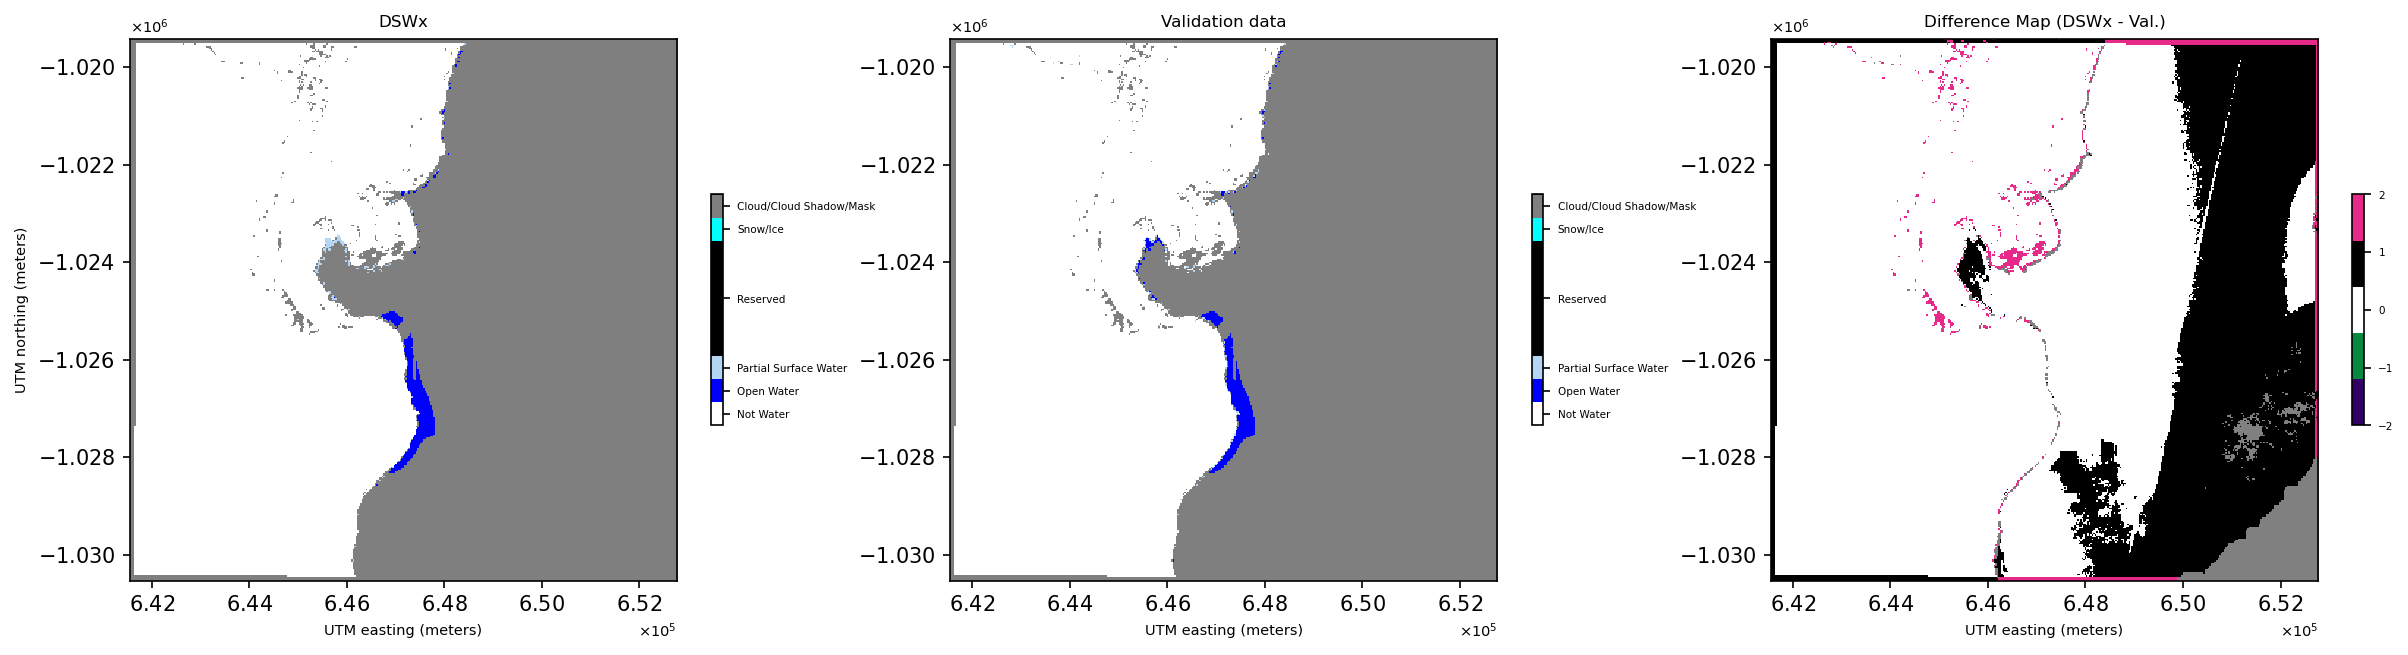

In [199]:
fontSize=7
fontSizeTitle=8
fig, axs = plt.subplots(1, 3, dpi=150, figsize=(20, 10))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])

X_dswx_c_m = X_dswx_c.copy()
X_dswx_c_m[shared_mask] = 9

im0 = axs[0].imshow(X_dswx_c_m, cmap=cmap, vmin=0, interpolation='none', vmax=255)
show(X_dswx_c_m, interpolation='none',cmap=cmap,vmin=0,vmax=255,transform=p_dswx_c['transform'],ax=axs[0])
axs[0].set_title('DSWx',fontsize=fontSizeTitle)
axs[0].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
axs[0].set_xlabel('UTM easting (meters)',fontsize=fontSize)
axs[0].set_ylabel('UTM northing (meters)',fontsize=fontSize)
axs[0].yaxis.get_offset_text().set_fontsize(fontSize)
axs[0].xaxis.get_offset_text().set_fontsize(fontSize)
cbar=fig.colorbar(im0,ax=axs[0],shrink=0.2,ticks=[0.5, 1.5, 2.5,5.5,8.5, 9.5])
cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Reserved','Snow/Ice','Cloud/Cloud Shadow/Mask'],fontsize=5,rotation=0)   
cbar.ax.set_ylim(0,10)
cbar.ax.tick_params(labelsize=5)

X_val_r_m = X_val_r.copy()
X_val_r_m[shared_mask] = 9

im1 = axs[1].imshow(X_val_r_m, cmap=cmap, vmin=0, interpolation='none', vmax=255)
show(X_val_r_m, interpolation='none',cmap=cmap,vmin=0,vmax=255,transform=p_val_r['transform'],ax=axs[1])
axs[1].set_title('Validation data',fontsize=fontSizeTitle)
axs[1].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
axs[1].set_xlabel('UTM easting (meters)',fontsize=fontSize)
axs[1].yaxis.get_offset_text().set_fontsize(fontSize)
axs[1].xaxis.get_offset_text().set_fontsize(fontSize)
cbar=fig.colorbar(im1,ax=axs[1],shrink=0.2,ticks=[0.5, 1.5, 2.5,5.5,8.5, 9.5])
cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Reserved','Snow/Ice','Cloud/Cloud Shadow/Mask'],fontsize=5)   
cbar.ax.set_ylim(0,10)
cbar.ax.tick_params(labelsize=5)

X_diff_m = X_diff.copy()
X_diff_m[shared_mask] = 9

cmapDiff=ListedColormap([(51/255,0/255, 102/255), (7/255, 137/255, 66/255), (1, 1, 1), (0,0,0),(231/255,41/255,138/255)])
im2 = axs[2].imshow(X_diff_m, interpolation='none',vmin=-2, vmax=2,cmap=cmapDiff)
show(X_diff, interpolation='none',vmin=-2, vmax=2,transform=p_val_r['transform'],ax=axs[2],cmap=cmapDiff)
axs[2].set_title('Difference Map (DSWx - Val.)',fontsize=fontSizeTitle)
axs[2].set_xlabel('UTM easting (meters)',fontsize=fontSize)
axs[2].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
axs[2].yaxis.get_offset_text().set_fontsize(fontSize)
axs[2].xaxis.get_offset_text().set_fontsize(fontSize)
cbar=fig.colorbar(im2,ax=axs[2],ticks=[-2,-1,0,1,2],shrink=0.2)
cbar.ax.tick_params(labelsize=6)
cbar.ax.set_ylim(-2,2)
cbar.ax.tick_params(labelsize=5)
im2.set_cmap(cmapDiff);
cmapDiff.set_bad(color='gray')



In [200]:
plt.close('all')

# For Presentations

In [201]:
presentation_dir = Path('presentation_images') / out_dir.name / DSWx_ID
presentation_dir.mkdir(exist_ok=True, parents=True)
presentation_dir

PosixPath('presentation_images/100-trials_conf-geq-70_sample-from-val/OPERA_L3_DSWx-HLS_T35LPK_20210924T080651Z_20230110T183515Z_S2A_30_v1.0')

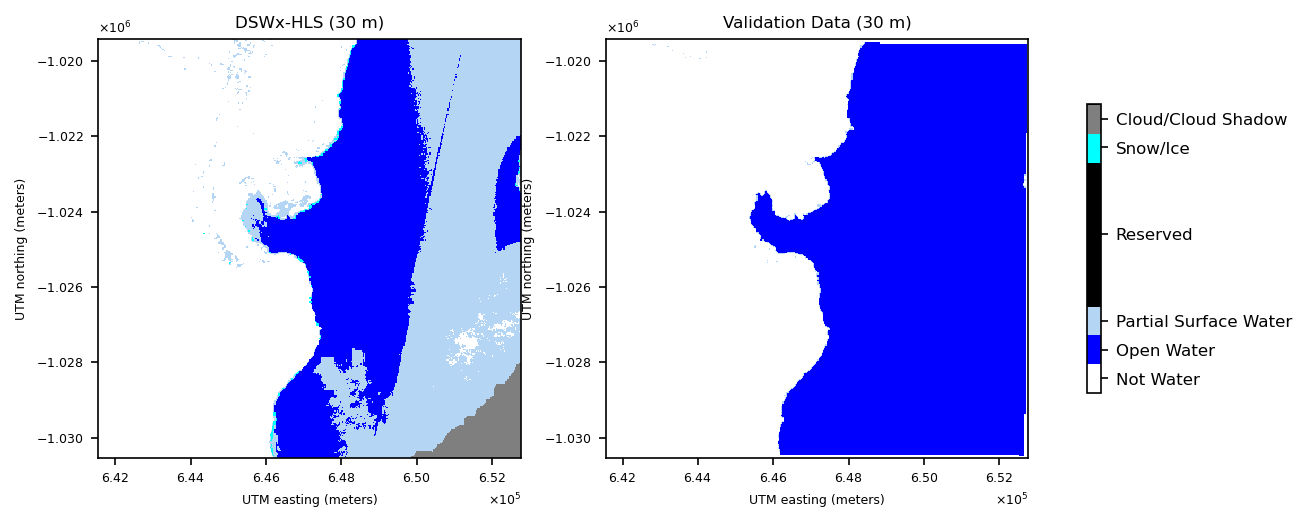

In [202]:
fontSize=6
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
im=ax[0].imshow(X_dswx_c, interpolation='none',cmap=cmap,vmin=0,vmax=255)

show(X_dswx_c, cmap=cmap, transform=p_dswx_c['transform'], interpolation='none', ax=ax[0], vmin=0,vmax=255)
ax[0].set_title('DSWx-HLS (30 m)',fontsize=8)
ax[0].set_xlabel('UTM easting (meters)',fontsize=fontSize)
ax[0].set_ylabel('UTM northing (meters)',fontsize=fontSize)
ax[0].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax[0].tick_params(axis='both', which='major', labelsize=fontSize)
ax[0].yaxis.get_offset_text().set_fontsize(fontSize)
ax[0].xaxis.get_offset_text().set_fontsize(fontSize)

show(X_val_r, cmap=cmap, transform=p_val_r['transform'], interpolation='none',ax=ax[1], vmin=0, vmax=255)
ax[1].set_title('Validation Data (30 m)',fontsize=8)
ax[1].set_xlabel('UTM easting (meters)',fontsize=fontSize)
ax[1].set_ylabel('UTM northing (meters)',fontsize=fontSize)

ax[1].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax[1].tick_params(axis='both', which='major', labelsize=fontSize)
ax[1].yaxis.get_offset_text().set_fontsize(fontSize)
ax[1].xaxis.get_offset_text().set_fontsize(fontSize)

display_mask = shared_mask.astype(np.float32)
display_mask[~shared_mask] = np.nan


cbar=fig.colorbar(im_dswx,
                  ax=ax,
                  ticks=[0.5, 1.5, 2.5,5.5,8.5, 9.5],
                  shrink=0.5,
                  orientation='vertical',
                  #fraction=0.32,
                  pad=.05
                 )
cbar.set_ticklabels(['Not Water', 
                     'Open Water',
                     'Partial Surface Water',
                     'Reserved',
                     'Snow/Ice',
                     'Cloud/Cloud Shadow'],
                    rotation=0)   
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_ylim(0,10);

#plt.tight_layout()
plt.savefig(presentation_dir / 'comparison_resample.png')


In [203]:
plt.close('all')

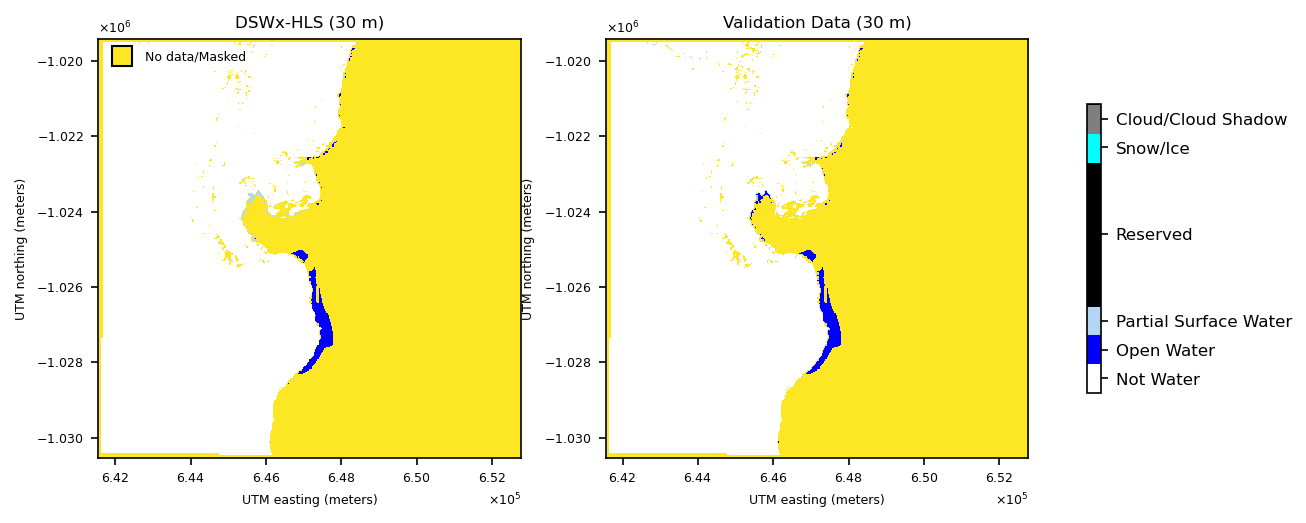

In [231]:
fontSize=6
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
im=ax[0].imshow(X_dswx_c, interpolation='none',cmap=cmap,vmin=0,vmax=255)

show(X_dswx_c, cmap=cmap, transform=p_dswx_c['transform'], interpolation='none', ax=ax[0], vmin=0,vmax=255)
ax[0].set_title('DSWx-HLS (30 m)',fontsize=8)
ax[0].set_xlabel('UTM easting (meters)',fontsize=fontSize)
ax[0].set_ylabel('UTM northing (meters)',fontsize=fontSize)
ax[0].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax[0].tick_params(axis='both', which='major', labelsize=fontSize)
ax[0].yaxis.get_offset_text().set_fontsize(fontSize)
ax[0].xaxis.get_offset_text().set_fontsize(fontSize)

show(X_val_r, cmap=cmap, transform=p_val_r['transform'], interpolation='none',ax=ax[1], vmin=0, vmax=255)
ax[1].set_title('Validation Data (30 m)',fontsize=8)
ax[1].set_xlabel('UTM easting (meters)',fontsize=fontSize)
ax[1].set_ylabel('UTM northing (meters)',fontsize=fontSize)

ax[1].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax[1].tick_params(axis='both', which='major', labelsize=fontSize)
ax[1].yaxis.get_offset_text().set_fontsize(fontSize)
ax[1].xaxis.get_offset_text().set_fontsize(fontSize)

display_mask = shared_mask.astype(np.float32)
display_mask[~shared_mask] = np.nan

show(display_mask, 
     cmap='viridis', 
     transform=p_val_r['transform'], 
     interpolation='none',
     ax=ax[1], vmin=0, vmax=1, alpha=1)
show(display_mask, 
     cmap='viridis', 
     transform=p_val_r['transform'], 
     interpolation='none',
     ax=ax[0], vmin=0, vmax=1, alpha=1)


cbar=fig.colorbar(im_dswx,
                  ax=ax,
                  ticks=[0.5, 1.5, 2.5,5.5,8.5, 9.5],
                  shrink=0.5,
                  orientation='vertical',
                  #fraction=0.32,
                  pad=.05
                 )
cbar.set_ticklabels(['Not Water', 
                     'Open Water',
                     'Partial Surface Water',
                     'Reserved',
                     'Snow/Ice',
                     'Cloud/Cloud Shadow'],
                    rotation=0)   
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_ylim(0,10);

### colorbar

# source: https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib

from matplotlib.lines import Line2D
from matplotlib import colors, colorbar, cm
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#import matplotlib.patches as mpatches
#from matplotlib.colors import LinearSegmentedColormap

cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap='viridis')
legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label='No data/Masked',
                          markerfacecolor=scalarMap.to_rgba(1),
                          markeredgecolor='black',
                          alpha=1,
                          markersize=10)]
ax[0].legend(handles=legend_elements, loc='upper left', fontsize=6,  framealpha=1, edgecolor='white')


# plt.tight_layout()
plt.savefig(presentation_dir / 'comparison_resample_with_mask.png')


In [205]:
plt.close('all')

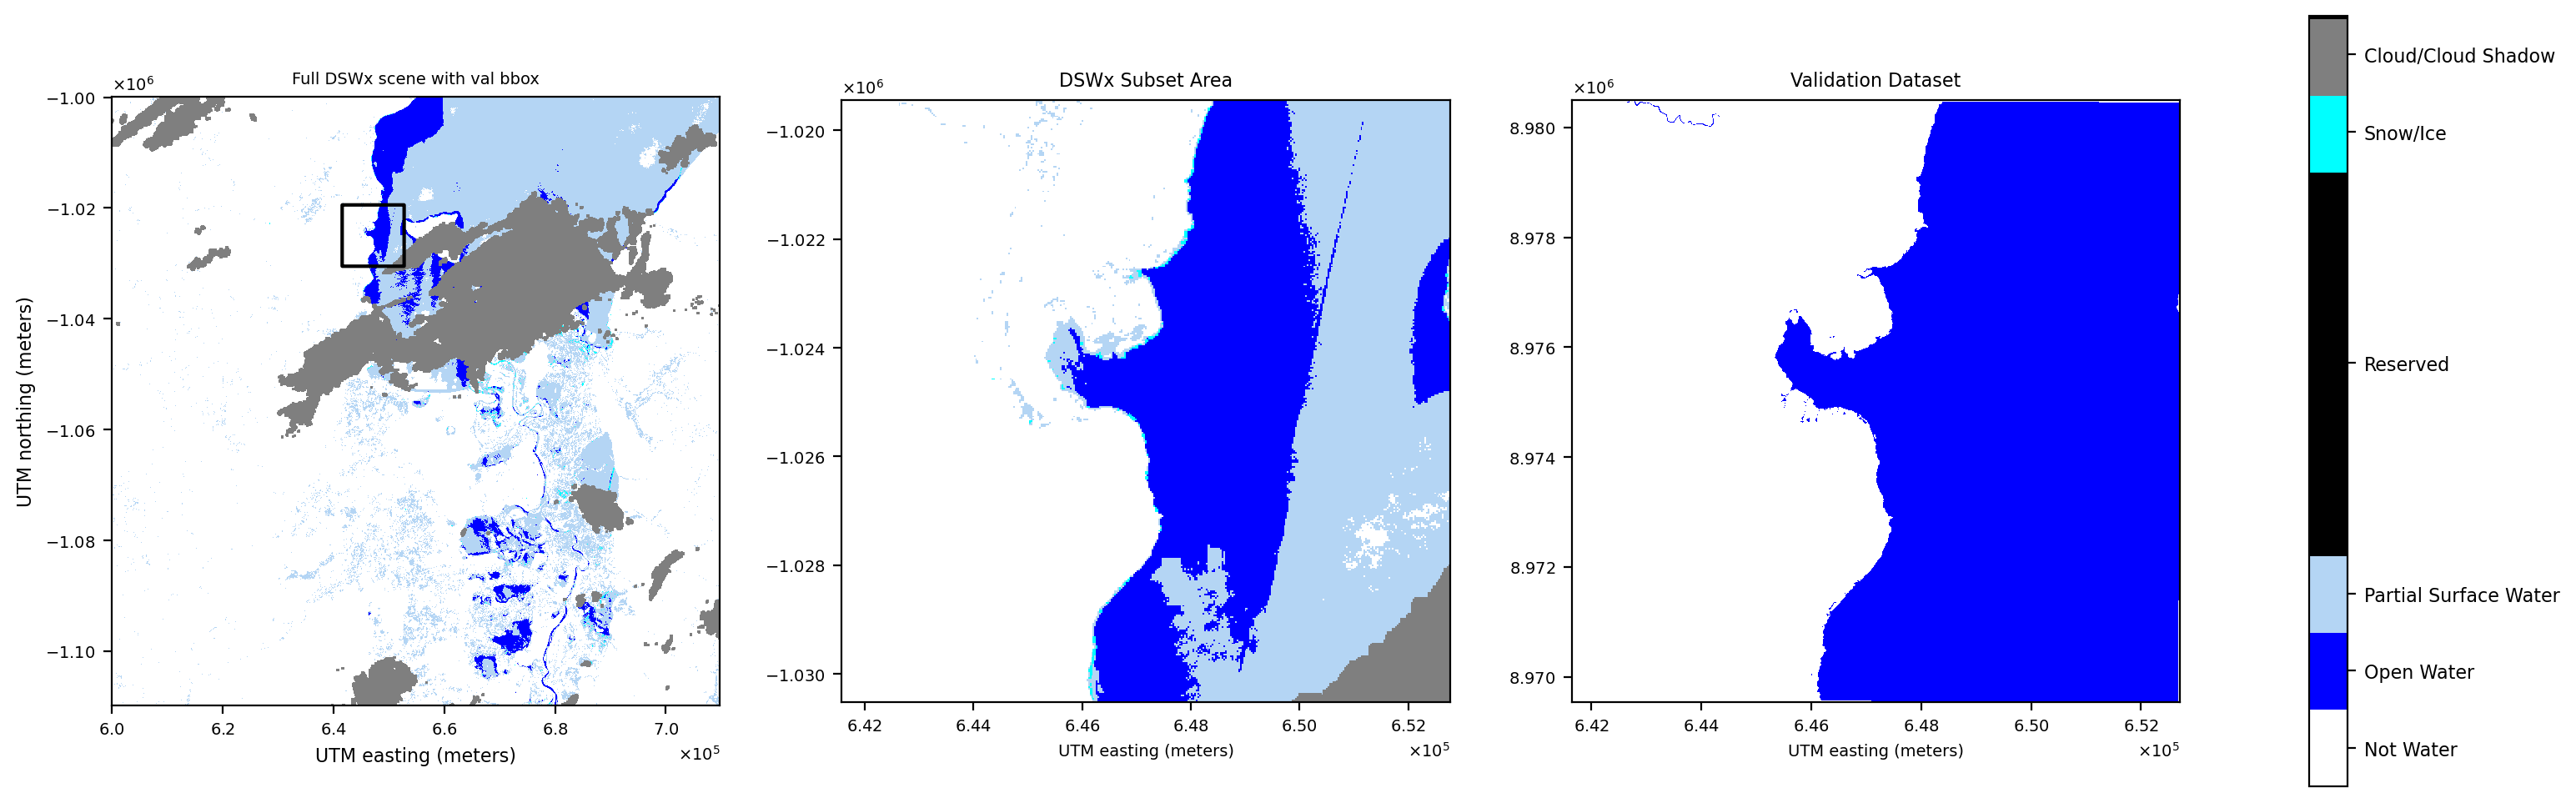

In [206]:
fontSize=7
fontSizeTitles=8
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(20, 10))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])

show(X_dswx, cmap=cmap, transform=p_dswx['transform'], vmin=0, vmax=255, interpolation='none', ax=ax[0])
df_val_bounds.to_crs(crs_dswx).boundary.plot(ax=ax[0], color='black')
ax[0].set_title('Full DSWx scene with val bbox',fontsize=fontSize)
ax[0].set_xlabel('UTM easting (meters)',fontsize=fontSizeTitles)
ax[0].set_ylabel('UTM northing (meters)',fontsize=fontSizeTitles)
ax[0].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax[0].tick_params(axis='both', which='major', labelsize=fontSize)
ax[0].yaxis.get_offset_text().set_fontsize(fontSize)
ax[0].xaxis.get_offset_text().set_fontsize(fontSize)

show(X_dswx, cmap=cmap, transform=p_dswx['transform'], vmin=0,vmax=255, interpolation='none', ax=ax[1])
val_bounds_dswx = df_val_bounds.to_crs(crs_dswx).total_bounds
ax[1].set_xlim(val_bounds_dswx[0], val_bounds_dswx[2])
ax[1].set_ylim(val_bounds_dswx[1], val_bounds_dswx[3])
ax[1].set_title('DSWx Subset Area',fontsize=fontSizeTitles)
ax[1].set_xlabel('UTM easting (meters)',fontsize=fontSize)
ax[1].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax[1].tick_params(axis='both', which='major', labelsize=fontSize)
ax[1].yaxis.get_offset_text().set_fontsize(fontSize)
ax[1].xaxis.get_offset_text().set_fontsize(fontSize)

show(X_val, transform=p_val['transform'], ax=ax[2], interpolation='none', cmap=cmap, vmin=0, vmax=255)
ax[2].set_title('Validation Dataset',fontsize=fontSizeTitles)
ax[2].set_xlabel('UTM easting (meters)',fontsize=fontSize)
ax[2].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax[2].tick_params(axis='both', which='major', labelsize=fontSize)
ax[2].yaxis.get_offset_text().set_fontsize(fontSize)
ax[2].xaxis.get_offset_text().set_fontsize(fontSize)

cbar=fig.colorbar(im_dswx,
                  ax=ax,
                  ticks=[0.5, 1.5, 2.5,5.5,8.5, 9.5],
                  shrink=0.6,
                  orientation='vertical',
                  #fraction=0.32,
                  pad=.05
                 )
cbar.set_ticklabels(['Not Water', 
                     'Open Water',
                     'Partial Surface Water',
                     'Reserved',
                     'Snow/Ice',
                     'Cloud/Cloud Shadow'],
                    rotation=0)   
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_ylim(0,10);

#plt.tight_layout()
plt.savefig(presentation_dir / 'extent.png')


In [207]:
plt.close('all')

In [208]:
df_all_samples.columns

Index(['total_accuracy', 'binary_water_acc', 'acc_per_class.Not_Water',
       'acc_per_class.Open_Surface_Water',
       'acc_per_class.Partial_Surface_Water',
       'confusion_matrix.Not_Water_OPERA_DSWx.Not_Water_OPERA_Validation',
       'confusion_matrix.Not_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation',
       'confusion_matrix.Not_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation',
       'confusion_matrix.Open_Surface_Water_OPERA_DSWx.Not_Water_OPERA_Validation',
       'confusion_matrix.Open_Surface_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation',
       'confusion_matrix.Open_Surface_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation',
       'confusion_matrix.Partial_Surface_Water_OPERA_DSWx.Not_Water_OPERA_Validation',
       'confusion_matrix.Partial_Surface_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation',
       'confusion_matrix.Partial_Surface_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation',
       'precision.Not_Water', 'precisi

In [209]:
COLUMNS = [col for col in df_all_samples.columns
           if ((('total_accuracy' in col) or
           ('precision' in col) or
           ('recall' in col) or
           ('f1' in col) or
           ('supp' in col)
            ) and
           ('Not_Water') not in col)]
COLUMNS

['total_accuracy',
 'precision.Open_Surface_Water',
 'precision.Partial_Surface_Water',
 'recall.Open_Surface_Water',
 'recall.Partial_Surface_Water',
 'f1_per_class.Open_Surface_Water',
 'f1_per_class.Partial_Surface_Water',
 'supp_per_class.Open_Surface_Water',
 'supp_per_class.Partial_Surface_Water']

In [210]:
COLUMN_RENAME = {'total_accuracy': 'Total Accuracy (All)',
                 'precision.Open_Surface_Water': 'Precision (OSW)',
                 'acc_per_class.Open_Surface_Water': 'Binary Accuracy (OSW)',
                 'acc_per_class.Partial_Surface_Water': 'Binary Accuracy (PSW)',
                 'precision.Partial_Surface_Water': 'Precision (PSW)',
                 'recall.Open_Surface_Water': 'Recall (OSW)',
                 'recall.Partial_Surface_Water': 'Recall (PSW)',
                 'supp_per_class.Open_Surface_Water': 'Support (Val) (OSW)',
                 'supp_per_class.Partial_Surface_Water': 'Support (Val) (PSW)',
                 'f1_per_class.Open_Surface_Water': 'F1 (OSW)',
                 'f1_per_class.Partial_Surface_Water': 'F1 (PSW)'}

In [211]:
df_temp = df_all_samples[COLUMNS].agg(['mean', 'median', 'std'])
df_temp.rename(columns=COLUMN_RENAME, inplace=True)

cols_not_supp = [col for col in df_temp.columns if 'Support' not in col]
df_temp[cols_not_supp] = df_temp[cols_not_supp] * 100

df_f = df_temp.T
df_f = df_f.round(2).astype(str)

df_f = df_f.reset_index(drop=False)
df_f = df_f.rename(columns={'index': 'Metric'})
df_f['Class'] = df_f.Metric.map(lambda m: m[-4:-1])
df_f['Metric'] = df_f.Metric.map(lambda m: m[:-6])
df_f['Metric'] = df_f.Metric.map(lambda m: m + ' ($\%$)' if 'Support' not in m else m)
df_f.sort_values(by=['Class', 'Metric'], inplace=True)
df_f = df_f.set_index(['Class', 'Metric'])
df_f.rename(columns={'mean': 'Mean', 
                     'std': 'St. Dev.', 
                     'median': 'Median'}, inplace=True)
df_f

Mean Median St. Dev.
Class Metric                                      
All   Total Accuracy ($\%$)  82.67   82.6     0.65
OSW   F1 ($\%$)              86.15  86.03     0.99
      Precision ($\%$)       80.66  80.63     0.31
      Recall ($\%$)          92.46  92.22     1.87
      Support (Val)          167.0  167.0      0.0
PSW   F1 ($\%$)              63.86  63.76     0.87
      Precision ($\%$)       85.33  84.88     3.16
      Recall ($\%$)          51.05  51.05      0.0
      Support (Val)          143.0  143.0      0.0

In [212]:
latex = df_f.style.to_latex(multirow_align='t', hrules=True)
with open(presentation_dir / 'accuracy.tex', 'w') as f:
    f.write(latex)

In [213]:
stats_data = df_sample_stats.to_dict('records')[0]
bw_mu = stats_data['binary_water_acc.mean']
bw_std = stats_data['binary_water_acc.std']

In [214]:
psw_str = f'{partial_surface_water_req} ({mu_psw:1.2f})'
osw_str = f'{open_surface_water_req} ({mu_osw:1.2f})'
df_requirement = pd.DataFrame([{'Class': 'PSW',
                                'OPERA Req.': partial_surface_water_req,
                                'Accuracy ($\%$)': f'{mu_psw * 100:1.2f} ({sigma_psw * 100:1.2f})'},
                               {'Class': 'OSW',
                                'OPERA Req.': open_surface_water_req,
                                'Accuracy ($\%$)': f'{mu_osw * 100:1.2f} ({sigma_osw * 100:1.2f})'},
                               {'Class': 'Binary Water',
                                'OPERA Req.': 'N/A',
                                'Accuracy ($\%$)': f'{bw_mu * 100:1.2f} ({bw_std * 100:1.2f})'}
                              ])

def labeler(val):
    if val:
        if val != 'N/A':
            return 'Passed'
        else:
            return val
    return 'Not Passed'

df_requirement['OPERA Req.'] = df_requirement['OPERA Req.'].map(labeler)
df_requirement

,Class,OPERA Req.,Accuracy ($\%$)
0,PSW,Passed,82.67 (0.65)
1,OSW,Passed,89.60 (0.65)
2,Binary Water,N/A,93.06 (0.06)


In [215]:
latex = df_requirement.style.hide(axis="index").to_latex(multirow_align='t', hrules=True)

with open(presentation_dir / 'requirements.tex', 'w') as f:
    f.write(latex)

In [216]:
CONFUSION_KEYS = ['confusion_matrix.Not_Water_OPERA_DSWx.Not_Water_OPERA_Validation',
                  'confusion_matrix.Not_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation',
                  'confusion_matrix.Not_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation',
                  'confusion_matrix.Open_Surface_Water_OPERA_DSWx.Not_Water_OPERA_Validation',
                  'confusion_matrix.Open_Surface_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation',
                  'confusion_matrix.Open_Surface_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation'
                  'confusion_matrix.Partial_Surface_Water_OPERA_DSWx.Not_Water_OPERA_Validation',
                  'confusion_matrix.Partial_Surface_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation',
                  'confusion_matrix.Partial_Surface_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation']



In [217]:
CONFUSION_COLUMNS = [col for col in df_all_samples.columns if 'confusion' in col]
CONFUSION_COLUMNS

['confusion_matrix.Not_Water_OPERA_DSWx.Not_Water_OPERA_Validation',
 'confusion_matrix.Not_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation',
 'confusion_matrix.Not_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation',
 'confusion_matrix.Open_Surface_Water_OPERA_DSWx.Not_Water_OPERA_Validation',
 'confusion_matrix.Open_Surface_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation',
 'confusion_matrix.Open_Surface_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation',
 'confusion_matrix.Partial_Surface_Water_OPERA_DSWx.Not_Water_OPERA_Validation',
 'confusion_matrix.Partial_Surface_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation',
 'confusion_matrix.Partial_Surface_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation']

In [218]:
confusion_dict = df_all_samples[CONFUSION_COLUMNS].agg(['mean', 'std']).to_dict()
confusion_dict

{'confusion_matrix.Not_Water_OPERA_DSWx.Not_Water_OPERA_Validation': {'mean': 166.92,
  'std': 0.2726599243442907},
 'confusion_matrix.Not_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation': {'mean': 0.0,
  'std': 0.0},
 'confusion_matrix.Not_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation': {'mean': 33.0,
  'std': 0.0},
 'confusion_matrix.Open_Surface_Water_OPERA_DSWx.Not_Water_OPERA_Validation': {'mean': 0.01,
  'std': 0.09999999999999999},
 'confusion_matrix.Open_Surface_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation': {'mean': 154.41,
  'std': 3.1207840247753333},
 'confusion_matrix.Open_Surface_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation': {'mean': 37.0,
  'std': 0.0},
 'confusion_matrix.Partial_Surface_Water_OPERA_DSWx.Not_Water_OPERA_Validation': {'mean': 0.07,
  'std': 0.2564323999762428},
 'confusion_matrix.Partial_Surface_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation': {'mean': 12.59,
  'std': 3.1207840247753333},
 'confusion_matrix.Partial

In [219]:
LABEL_NAMES = ['Not_Water',  'Open_Surface_Water', 'Partial_Surface_Water']
temp_dict = confusion_dict.copy()
conf_mean = [[temp_dict.setdefault(f'confusion_matrix.{label_1}_OPERA_DSWx.{label_2}_OPERA_Validation', {'mean': 0})['mean']
                       for label_1 in LABEL_NAMES] 
                      for label_2 in LABEL_NAMES]
conf_mean

[[166.92, 0.01, 0.07], [0.0, 154.41, 12.59], [33.0, 37.0, 73.0]]

In [220]:
LABEL_NAMES = ['Not_Water',  'Open_Surface_Water', 'Partial_Surface_Water']
temp_dict = confusion_dict.copy()
conf_std = [[temp_dict.setdefault(f'confusion_matrix.{label_2}_OPERA_DSWx.{label_1}_OPERA_Validation', {'std': 0})['std']
                       for label_1 in LABEL_NAMES] 
                      for label_2 in LABEL_NAMES]
conf_std

[[0.2726599243442907, 0.0, 0.0],
 [0.09999999999999999, 3.1207840247753333, 0.0],
 [0.2564323999762428, 3.1207840247753333, 0.0]]

In [221]:
conf_data = [[f'{mu:1.2f} ({std:1.2f})' for (mu, std) in zip(mu_list, std_list)] for (mu_list, std_list) in zip(conf_mean, conf_std)]

In [222]:
df_confusion = pd.DataFrame(conf_data,
                            index=['NW (DSWx)', 'OSW (DSWx)', 'PSW (DSWx)'],
                            columns=['NW (Val)', 'OSW (Val)', 'PSW (Val)']
                           )
df_confusion

,NW (Val),OSW (Val),PSW (Val)
NW (DSWx),166.92 (0.27),0.01 (0.00),0.07 (0.00)
OSW (DSWx),0.00 (0.10),154.41 (3.12),12.59 (0.00)
PSW (DSWx),33.00 (0.26),37.00 (3.12),73.00 (0.00)


In [223]:
latex = df_confusion.style.to_latex(multirow_align='t', hrules=True)
with open(presentation_dir / 'confusion.tex', 'w') as f:
    f.write(latex)

## Omission and Comission Error

In [224]:
stats_data = df_sample_stats.to_dict('records')[0]
stats_data

{'total_accuracy.mean': 0.8266876310272536,
 'total_accuracy.std': 0.006515053013073894,
 'binary_water_acc.mean': 0.930649895178197,
 'binary_water_acc.std': 0.0005716140971578522,
 'acc_per_class.Not_Water.mean': 0.930649895178197,
 'acc_per_class.Not_Water.std': 0.0005716140971578522,
 'acc_per_class.Open_Surface_Water.mean': 0.8960167714884696,
 'acc_per_class.Open_Surface_Water.std': 0.006535089799902489,
 'acc_per_class.Partial_Surface_Water.mean': 0.8267085953878407,
 'acc_per_class.Partial_Surface_Water.std': 0.006522986638112563,
 'confusion_matrix.Not_Water_OPERA_DSWx.Not_Water_OPERA_Validation.mean': 166.92,
 'confusion_matrix.Not_Water_OPERA_DSWx.Not_Water_OPERA_Validation.std': 0.2726599243442907,
 'confusion_matrix.Not_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation.mean': 0.0,
 'confusion_matrix.Not_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation.std': 0.0,
 'confusion_matrix.Not_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation.mean': 33.0,
 'confusion_m

In [225]:
table_data = [{'Class': label,
               'Omission Error Mean': 1 - stats_data[f'precision.{label}.mean'],
               'Commision Error Mean': 1 - stats_data[f'recall.{label}.mean'],
               'Omission Error std': stats_data[f'precision.{label}.std'],
               'Commision Error std': stats_data[f'recall.{label}.std']} 
              for label in LABEL_NAMES]
df_om_com = pd.DataFrame(table_data)
renamer = {'Not_Water': 'NW', 'Open_Surface_Water': 'OSW', 'Partial_Surface_Water': 'PSW'}
df_om_com['Class'] = df_om_com['Class'].map(lambda x: renamer[x])
classes = df_om_com['Class'].values
df_om_com['Omission Error ($\%$)'] = df_om_com.apply(lambda row: f'{row["Omission Error Mean"] * 100: .2f} ({row["Omission Error std"] * 100:.2f})',axis=1)
df_om_com['Commision Error ($\%$)'] = df_om_com.apply(lambda row: f'{row["Commision Error Mean"] * 100: .2f} ({row["Commision Error std"] * 100:.2f})',axis=1)
df_om_com = df_om_com[['Commision Error ($\%$)', 'Omission Error ($\%$)']].copy()
df_om_com.index = classes
df_om_com

,Commision Error ($\%$),Omission Error ($\%$)
NW,0.05 (0.16),16.51 (0.02)
OSW,7.54 (1.87),19.34 (0.31)
PSW,48.95 (0.00),14.67 (3.16)


In [226]:
latex = df_om_com.style.to_latex(multirow_align='t', hrules=True)
with open(presentation_dir / 'omission_comission.tex', 'w') as f:
    f.write(latex)

# Area of each class

In [227]:
C_val = 9
C_dswx = 900
C_ha = 0.0001
area_data = [{'Type': 'Val',
              'Frame (Posting)': 'Validation (3 m)',
              'Class': 'OSW',
              'Area (ha)': (X_val == 1).sum() * C_ha * C_val,
              'Area ($\%$)': (X_val == 1).sum() / (X_val != 255).sum() * 100},
             {'Type': 'Val',
              'Frame (Posting)': 'Validation (3 m)',
              'Class': 'NW',
              'Area (ha)': (X_val == 0).sum() * C_ha * C_val,
              'Area ($\%$)': (X_val == 0).sum() / (X_val != 255).sum() * 100},
             {'Type': 'Val',
              'Frame (Posting)': 'DSWx (30 m)',
              'Class': 'OSW',
              'Area (ha)': (X_val_r[~shared_mask] == 1).sum() * C_ha * C_dswx,
              'Area ($\%$)': (X_val_r[~shared_mask] == 1).sum() / (~shared_mask).sum() * 100},
             {'Type': 'Val',
              'Frame (Posting)': 'DSWx (30 m)',
              'Class': 'PSW',
              'Area (ha)': (X_val_r[~shared_mask] == 2).sum() * C_ha * C_dswx,
              'Area ($\%$)': (X_val_r[~shared_mask] == 2).sum() / (~shared_mask).sum() * 100
             },
             {'Type': 'Val',
              'Frame (Posting)': 'DSWx (30 m)',
              'Class': 'NW',
              'Area (ha)': (X_val_r[~shared_mask] == 0).sum() * C_ha * C_dswx,
              'Area ($\%$)': (X_val_r[~shared_mask] == 0).sum() / (~shared_mask).sum() * 100
             },
             {'Type': 'DSWx',
              'Frame (Posting)': 'DSWx (30 m)',
              'Class': 'OSW',
              'Area (ha)': (X_dswx_c[~shared_mask] == 1).sum() * C_ha * C_dswx,
              'Area ($\%$)': (X_dswx_c[~shared_mask] == 1).sum() / (~shared_mask).sum() * 100},
             {'Type': 'DSWx',
              'Frame (Posting)': 'DSWx (30 m)',
              'Class': 'PSW',
              'Area (ha)': (X_dswx_c[~shared_mask] == 2).sum() * C_ha * C_dswx,
              'Area ($\%$)': (X_dswx_c[~shared_mask] == 2).sum() / (~shared_mask).sum() * 100
             },
             {'Type': 'DSWx',
              'Frame (Posting)': 'DSWx (30 m)',
              'Class': 'NW',
              'Area (ha)': (X_dswx_c[~shared_mask] == 0).sum() * C_ha * C_dswx,
              'Area ($\%$)': (X_dswx_c[~shared_mask] == 0).sum() / (~shared_mask).sum() * 100
             }
            ]
df_area = pd.DataFrame(area_data)
df_area

,Type,Frame (Posting),Class,Area (ha),Area ($\%$)
0,Val,Validation (3 m),OSW,6115.9095,50.880861
1,Val,Validation (3 m),NW,5904.1494,49.119139
2,Val,DSWx (30 m),OSW,84.1500,1.425022
3,Val,DSWx (30 m),PSW,12.8700,0.217945
4,Val,DSWx (30 m),NW,5808.1500,98.357033
5,DSWx,DSWx (30 m),OSW,81.3600,1.377776
6,DSWx,DSWx (30 m),PSW,15.3000,0.259095
7,DSWx,DSWx (30 m),NW,5808.5100,98.363129


In [228]:
df_area_f = df_area.set_index(['Frame (Posting)', 'Type', 'Class'])
df_area_f['Area (ha)'] = df_area_f['Area (ha)'].map(lambda num: f'{num:1.2f}')
df_area_f['Area ($\%$)'] = df_area_f['Area ($\%$)'].map(lambda num: f'{num:1.2f}')
df_area_f

Area (ha) Area ($\%$)
Frame (Posting)  Type Class                      
Validation (3 m) Val  OSW     6115.91       50.88
                      NW      5904.15       49.12
DSWx (30 m)      Val  OSW       84.15        1.43
                      PSW       12.87        0.22
                      NW      5808.15       98.36
                 DSWx OSW       81.36        1.38
                      PSW       15.30        0.26
                      NW      5808.51       98.36

In [229]:
latex = df_area_f.style.to_latex(multirow_align='t', hrules=True)
with open(presentation_dir / 'areas.tex', 'w') as f:
    f.write(latex)

In [230]:
latex_0 = "\\begin{verbatim}\n" + "Planet ID: " + PLANET_ID + "\n\\end{verbatim}\n"
latex_1 = "\\begin{verbatim}\n" + "Site Name: " + SITE_NAME + "\n\\end{verbatim}\n"
latex = latex_0 + latex_1
print(latex)

\begin{verbatim}
Planet ID: 20210924_082025_48_2424
\end{verbatim}
\begin{verbatim}
Site Name: 4_37
\end{verbatim}



In [132]:
with open(presentation_dir / 'more_ids.tex', 'w') as f:
    f.write(latex)